In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST 
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(123)

c:\Users\ivanr\AppData\Local\anaconda3\envs\PhD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load MNIST dataset as tensors using DataLoader class
batch_size = 128
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

def tensor_to_images(image_tensor, num_images=30, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=6)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dimension=10, 
                       image_dimension=784, 
                       hidden_dimension=128):
        super(Generator, self).__init__()
        
        self.n_dim = noise_dimension
        self.im_dim = image_dimension
        self.h_dim = hidden_dimension

        # Generator network
        self.gen = nn.Sequential(
            self.generator_block(self.n_dim, self.h_dim),
            self.generator_block(self.h_dim, self.h_dim * 2),
            self.generator_block(self.h_dim * 2, self.h_dim * 4),
            self.generator_block(self.h_dim * 4, self.h_dim * 8),
            nn.Linear(self.h_dim * 8, self.im_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)

    # Simple neural network single block
    def generator_block(self, in_dimension, out_dimension):
        return nn.Sequential(
            nn.Linear(in_dimension, out_dimension),
            nn.BatchNorm1d(out_dimension),
            nn.ReLU(inplace=True),
        )

In [4]:
def get_noise(n_samples, noise_vector_dimension, device='cpu'):
    return torch.randn(n_samples, noise_vector_dimension,device=device)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, 
                 image_dimension=784, 
                 hidden_dimension=128):
        super(Discriminator, self).__init__()

        self.im_dim = image_dimension
        self.h_dim = hidden_dimension

        self.disc = nn.Sequential(
            self.discriminator_block(self.im_dim, self.h_dim * 4),
            self.discriminator_block(self.im_dim * 4, self.h_dim * 2),
            self.discriminator_block(self.im_dim * 2, self.h_dim),
            nn.Linear(self.h_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)

    def discriminator_block(self, in_dimension, out_dimension):
      return nn.Sequential(
           nn.Linear(in_dimension, out_dimension),
           nn.LeakyReLU(0.2, inplace=True)
      )

In [6]:
# Hyperparameters for training loop
n_epochs = 5
noise_dimension = 64
lr = 0.00001
display_step = 500

criterion = nn.BCEWithLogitsLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# Generator & Optimizer for Generator
gen = Generator(noise_dimension).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

# Discriminator & Optimizer for Discriminator
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [8]:
def get_disc_loss(gen, disc, criterion, real, num_images, noise_dimension, device):
    # Generate noise and pass to generator
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)
    
    # Pass fake features to discriminator
    # All of them will got label as 0
    # .detach() here is to ensure that only discriminator parameters will get update
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, 
                               torch.zeros_like(disc_fake_pred))
    
    # Pass real features to discriminator
    # All of them will got label as 1
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, 
                               torch.ones_like(disc_real_pred))

    # Average of loss from both real and fake features
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, noise_dimension, device):
    # Generate noise and pass to generator
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)

    # Pass fake features to discriminator
    # But all of them will got label as 1
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [9]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        # Get number of batch size (number of image)
        # And get tensor for each image in batch
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)
        
        ### Traing discriminator ###
        # Zero out the gradient .zero_grad()
        # Calculate discriminator loss get_disc_loss()
        # Update gradient .gradient() 
        # Update optimizer .step()
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, noise_dimension, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        ### Traing generator ###
        # Zero out the gradient .zero_grad()
        # Calculate discriminator loss get_gen_loss()
        # Update gradient .gradient() 
        # Update optimizer .step()
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, noise_dimension, device)
        gen_loss.backward()
        gen_opt.step()

        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, noise_dimension, device=device)
            fake = gen(fake_noise)
            tensor_to_images(fake)
            tensor_to_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0

        cur_step += 1

  0%|          | 0/469 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x512 and 3136x256)

Preparing training run 52fd0acb-a046-4789-9beb-3e3d07d98bb0
Starting epoch 0...
Losses after mini-batch     0: generator 6.745945e-01, discriminator 1.373560e+00
Losses after mini-batch    50: generator 1.026909e+00, discriminator 1.225723e+00
Losses after mini-batch   100: generator 1.077340e+00, discriminator 1.022945e+00
Losses after mini-batch   150: generator 2.288107e+00, discriminator 7.656114e-01
Losses after mini-batch   200: generator 2.577887e+00, discriminator 1.366480e-01
Losses after mini-batch   250: generator 4.082230e+00, discriminator 8.442377e-02
Losses after mini-batch   300: generator 5.715042e+00, discriminator 5.296227e-02
Losses after mini-batch   350: generator 8.232148e-01, discriminator 2.138590e+00
Losses after mini-batch   400: generator 3.533583e+00, discriminator 9.361412e-02
Losses after mini-batch   450: generator 3.322413e+00, discriminator 8.974078e-02
Starting epoch 1...
Losses after mini-batch     0: generator 4.253712e+00, discriminator 7.697898e-0

C:\Users\ivanr\AppData\Local\Temp\ipykernel_17440\3023861395.py:101: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


Losses after mini-batch    50: generator 4.980438e+00, discriminator 1.150701e-01
Losses after mini-batch   100: generator 5.406403e+00, discriminator 4.917486e-02
Losses after mini-batch   150: generator 4.217507e+00, discriminator 7.302490e-02
Losses after mini-batch   200: generator 5.180984e+00, discriminator 3.476961e-01
Losses after mini-batch   250: generator 4.703505e+00, discriminator 1.607072e-01
Losses after mini-batch   300: generator 3.809147e+00, discriminator 1.773065e-01
Losses after mini-batch   350: generator 5.188951e+00, discriminator 2.610472e-01
Losses after mini-batch   400: generator 4.080169e+00, discriminator 2.908463e-01
Losses after mini-batch   450: generator 3.584731e+00, discriminator 1.280889e-01
Starting epoch 3...
Losses after mini-batch     0: generator 4.850626e+00, discriminator 2.781234e-01
Losses after mini-batch    50: generator 2.297467e+00, discriminator 2.249479e-01
Losses after mini-batch   100: generator 2.805717e+00, discriminator 2.987764e

KeyboardInterrupt: 

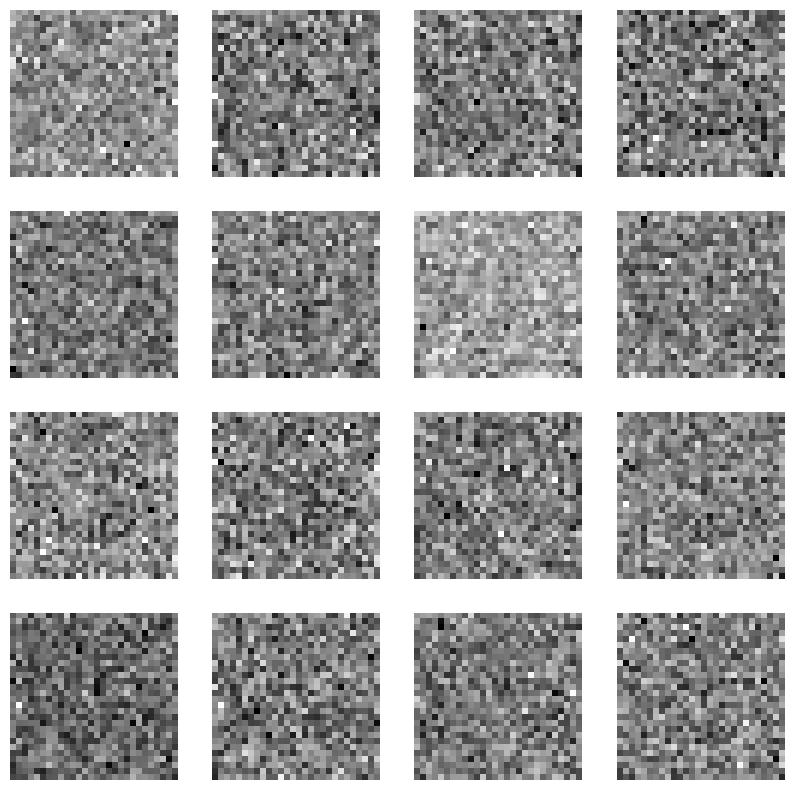

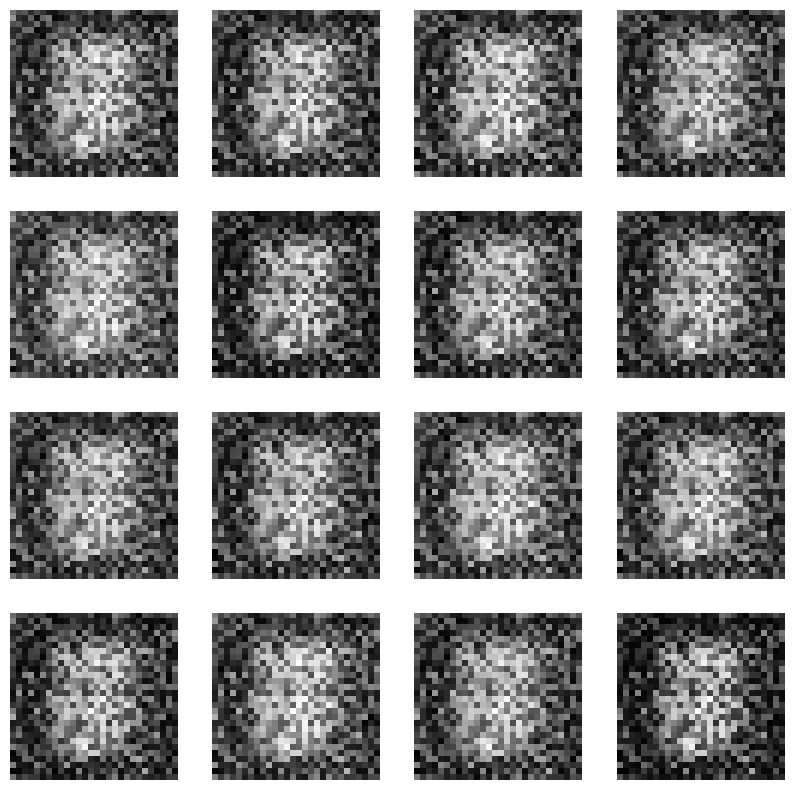

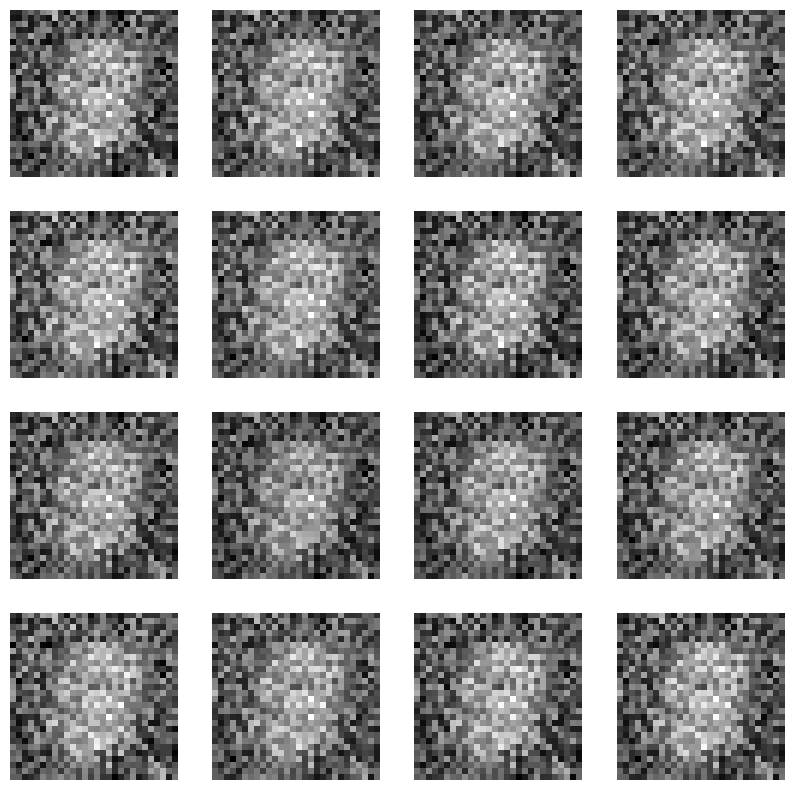

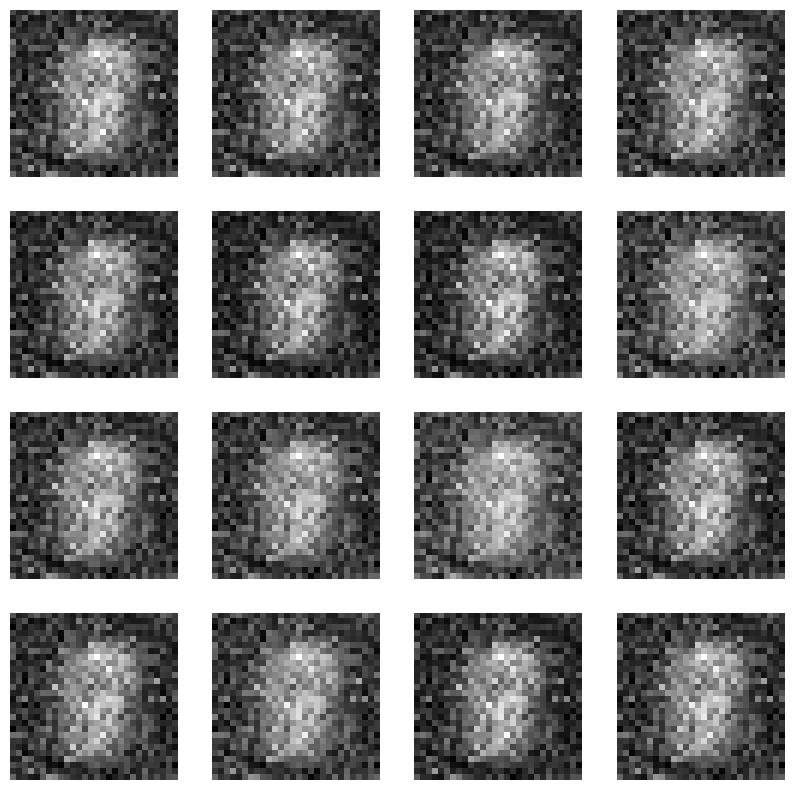

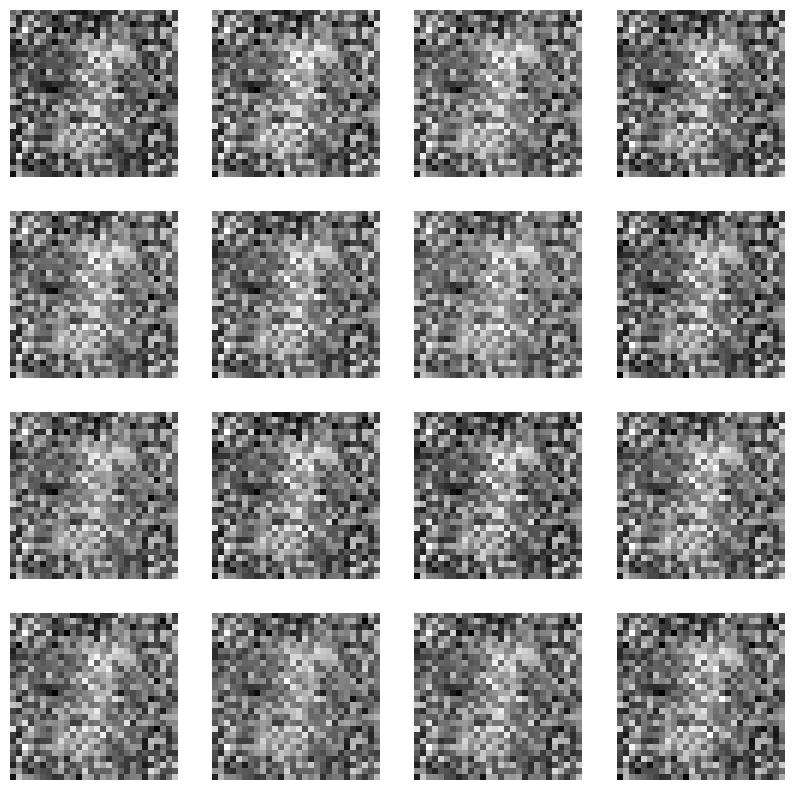

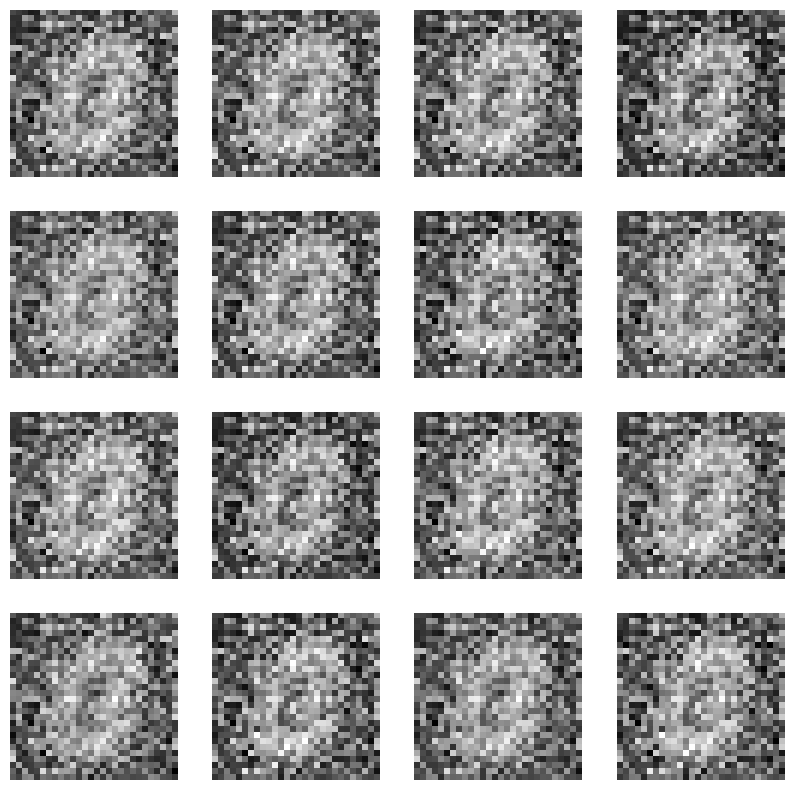

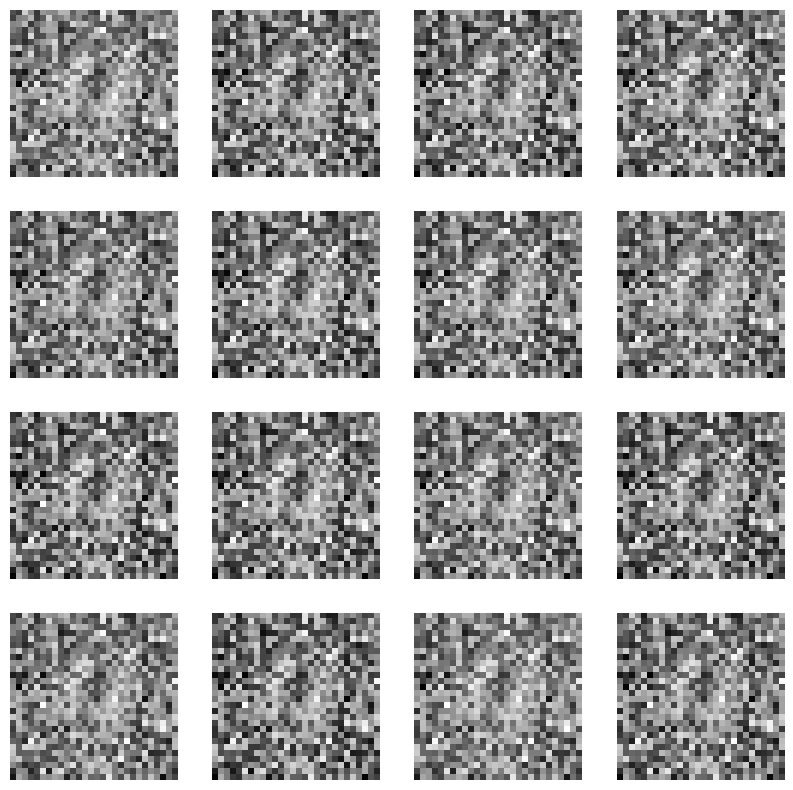

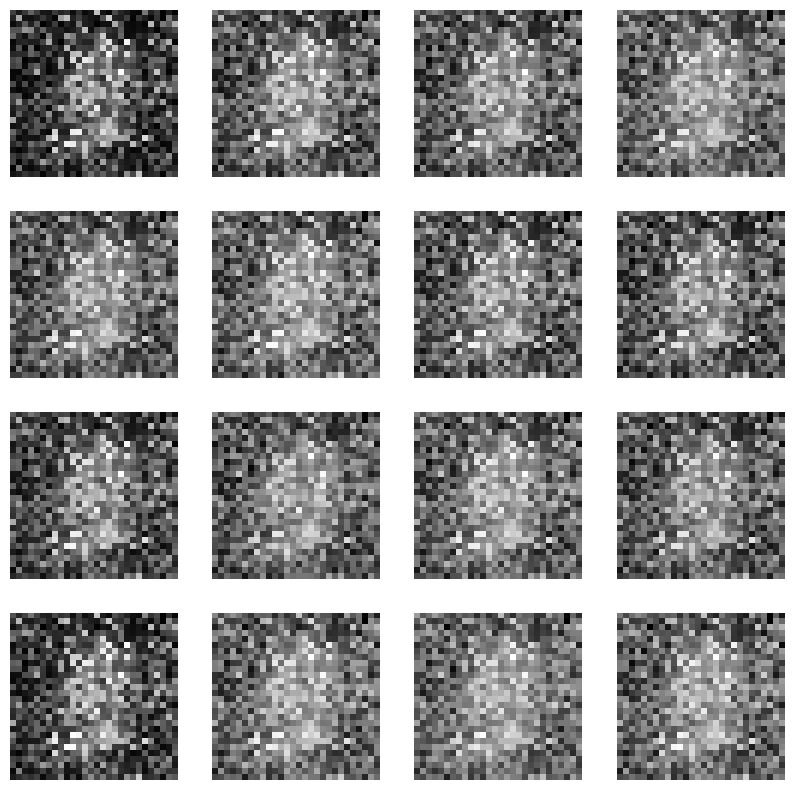

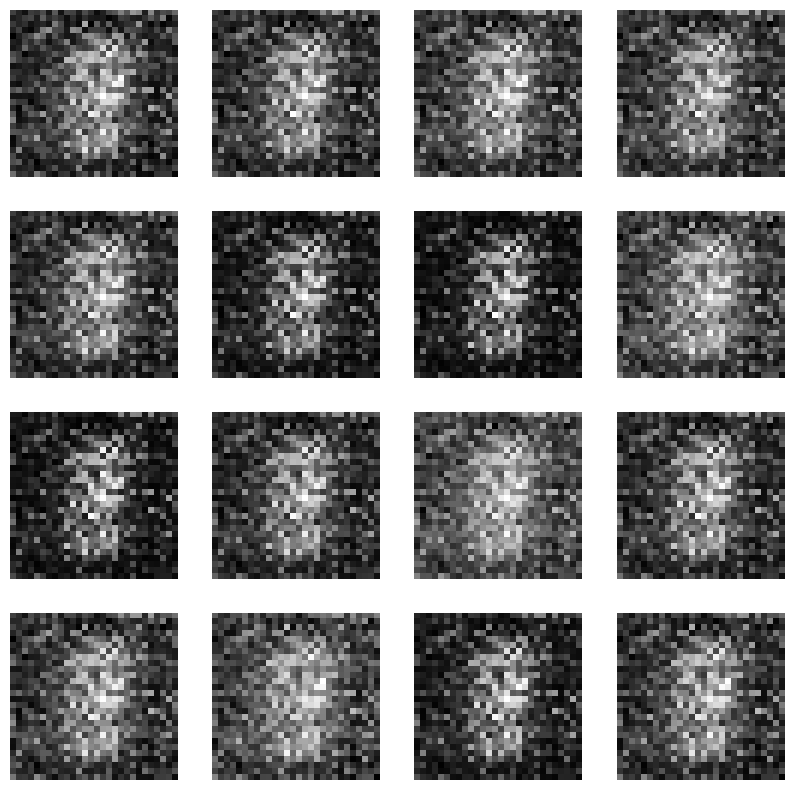

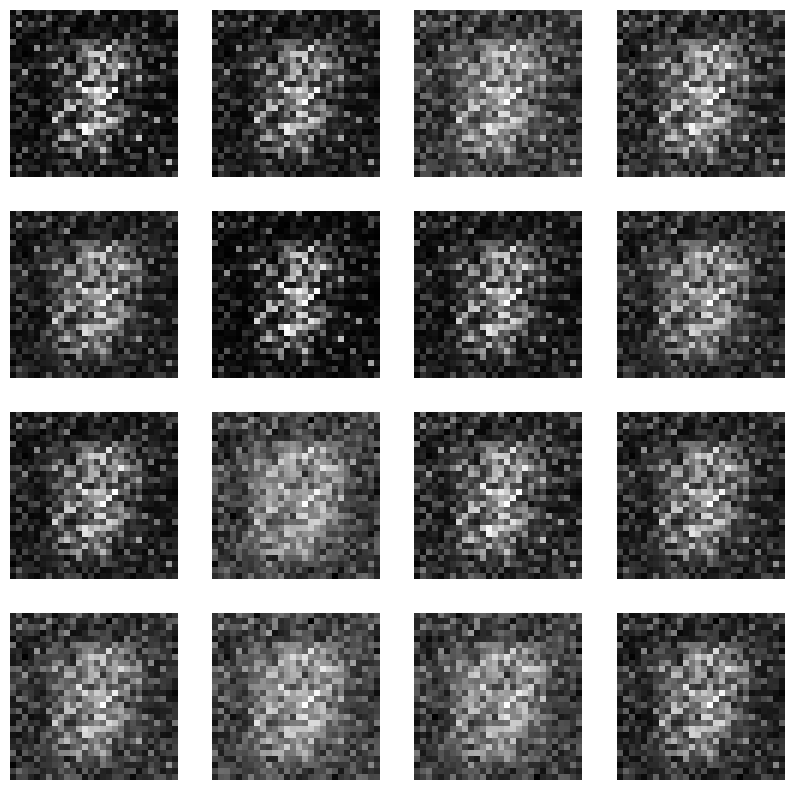

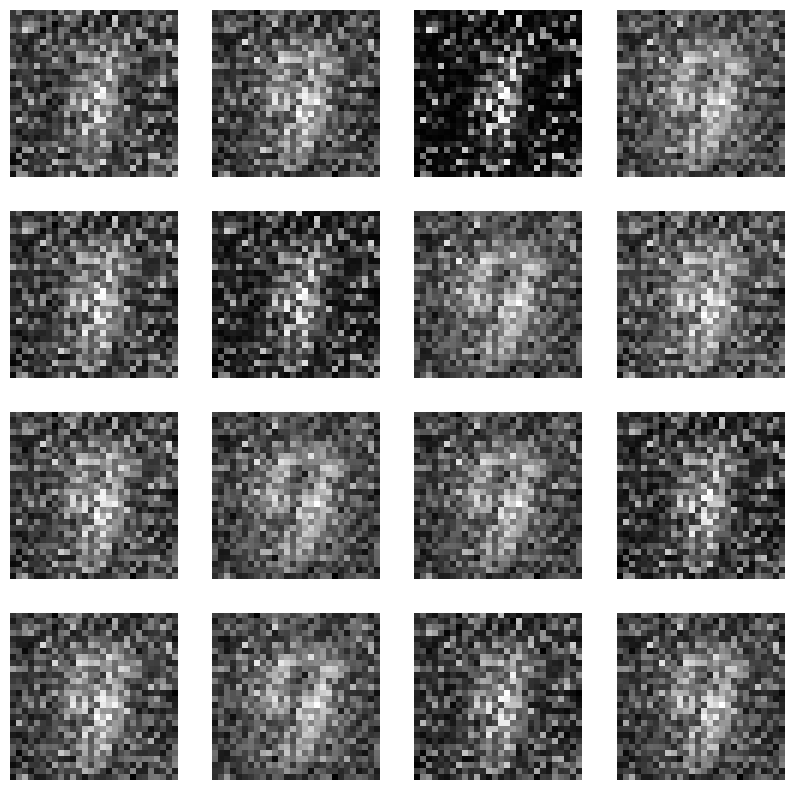

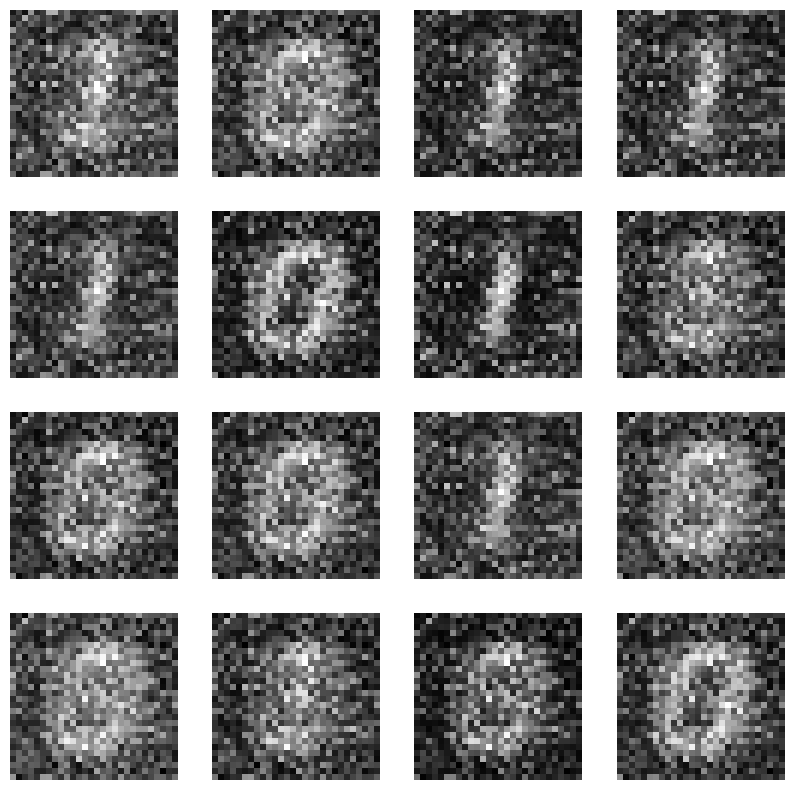

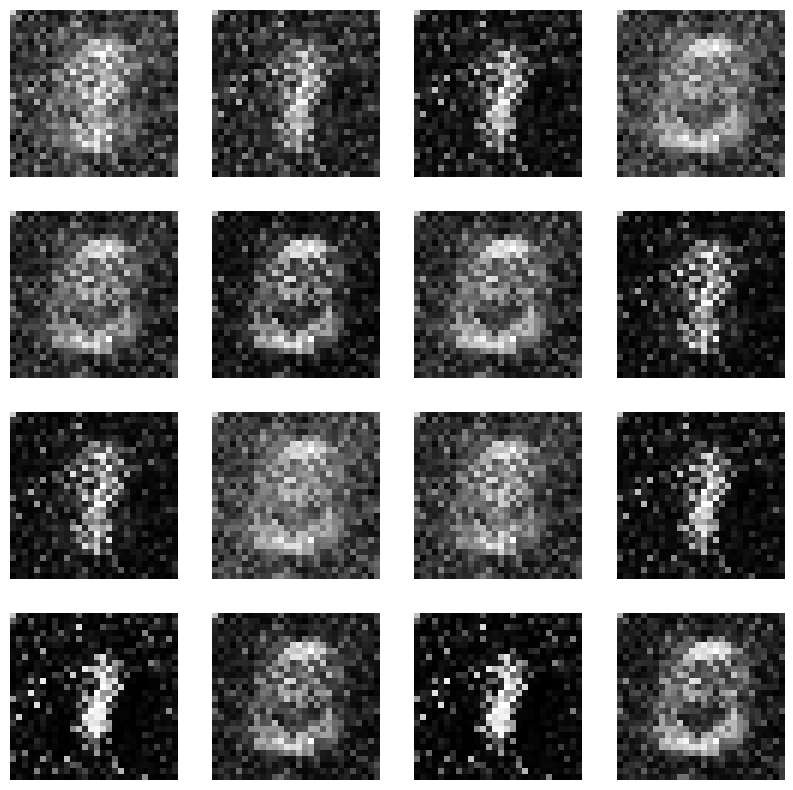

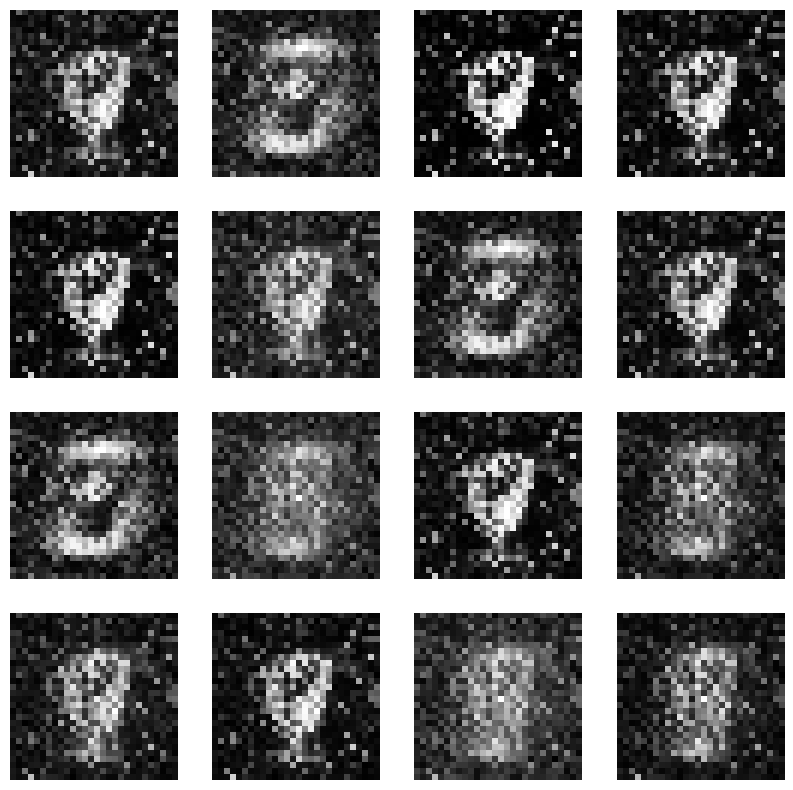

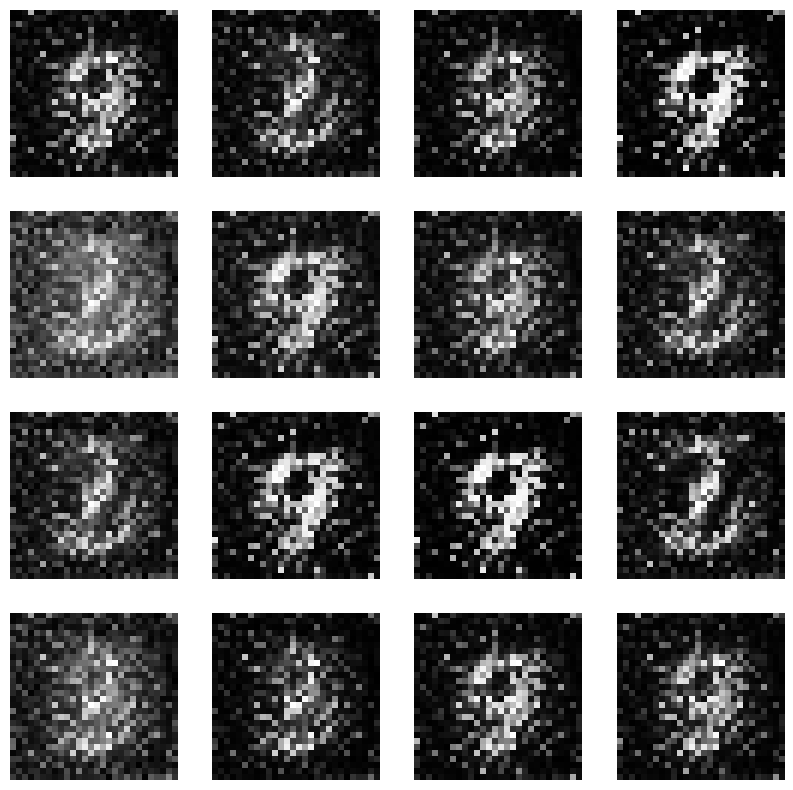

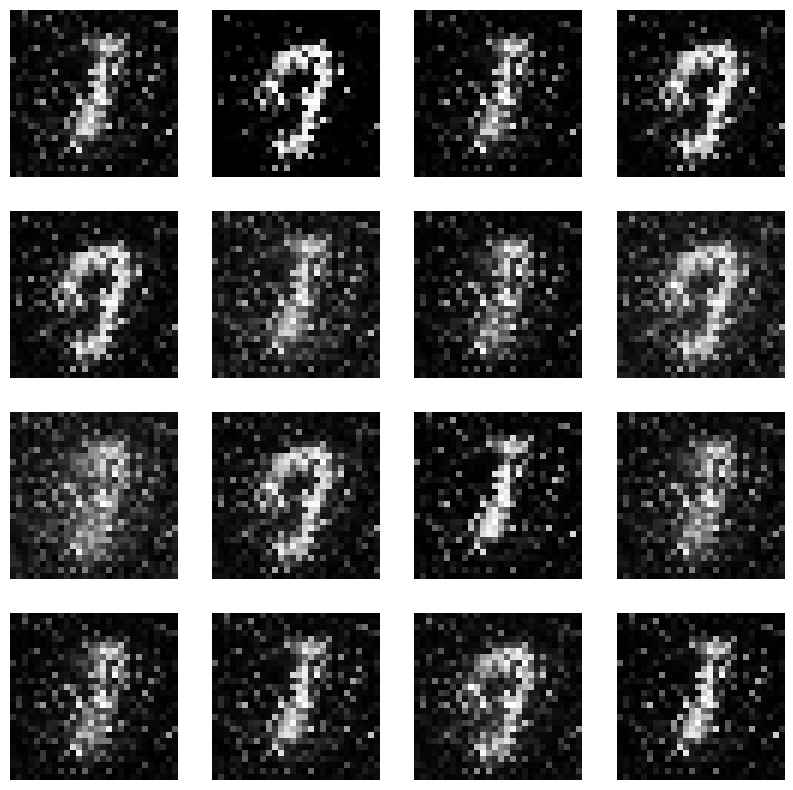

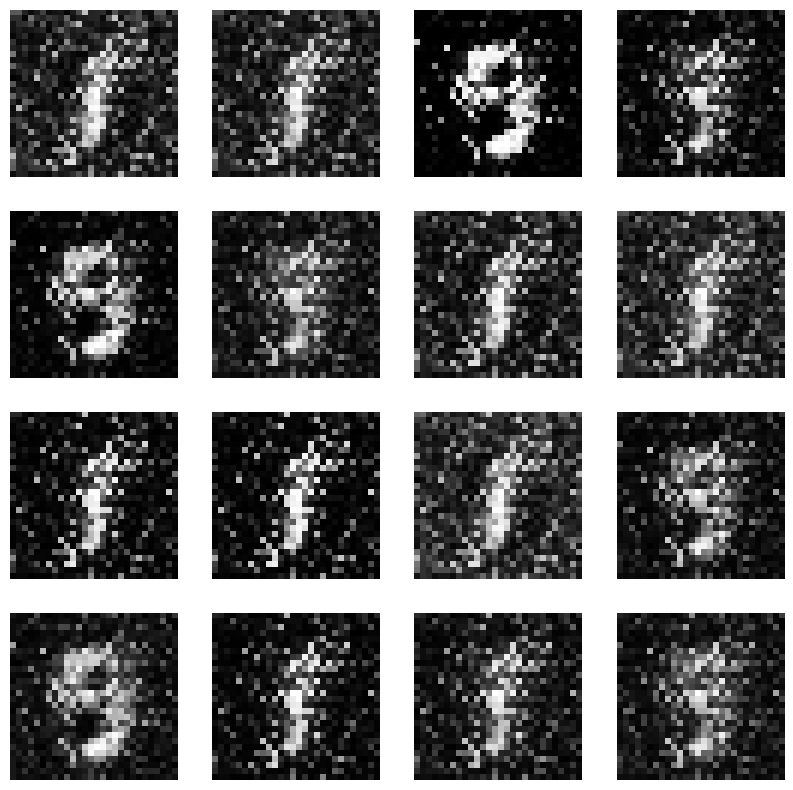

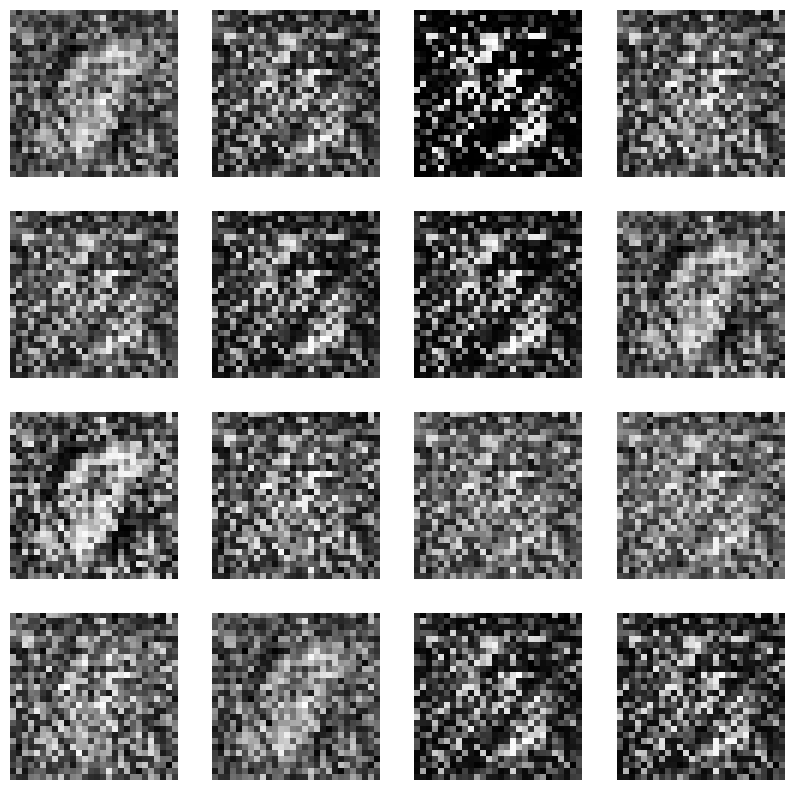

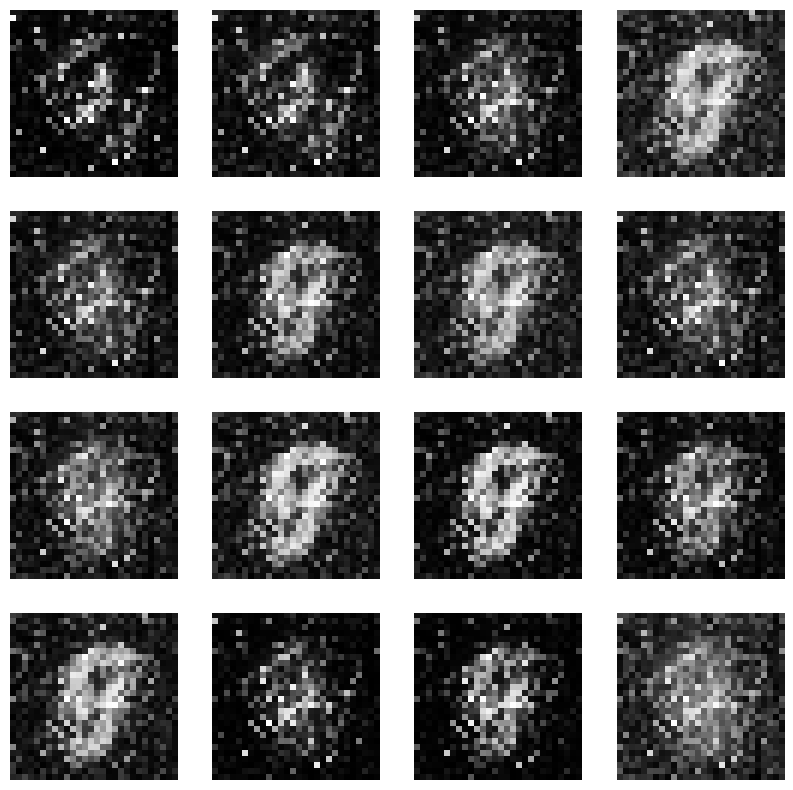

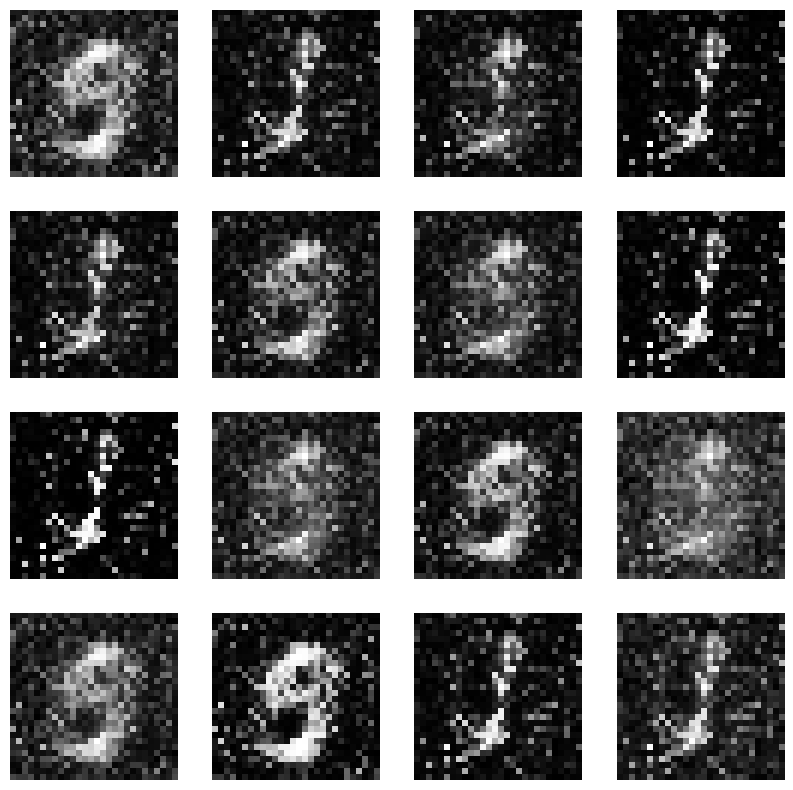

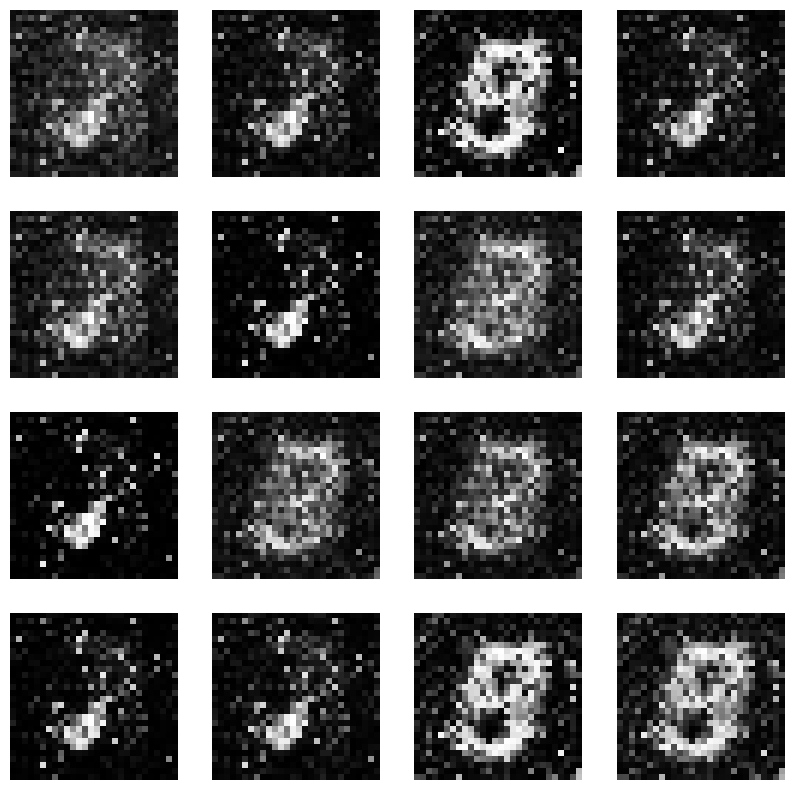

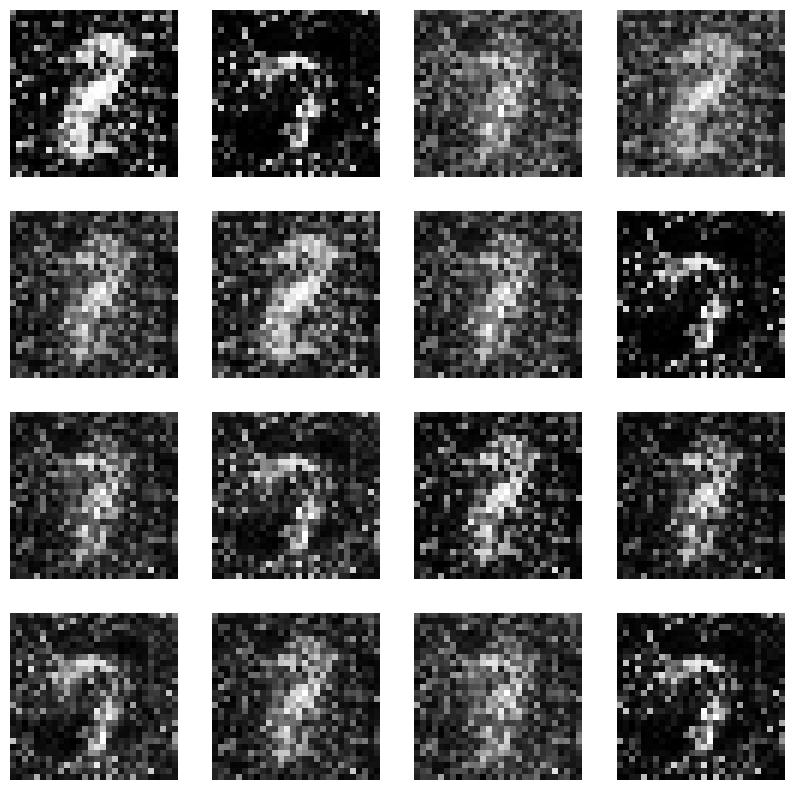

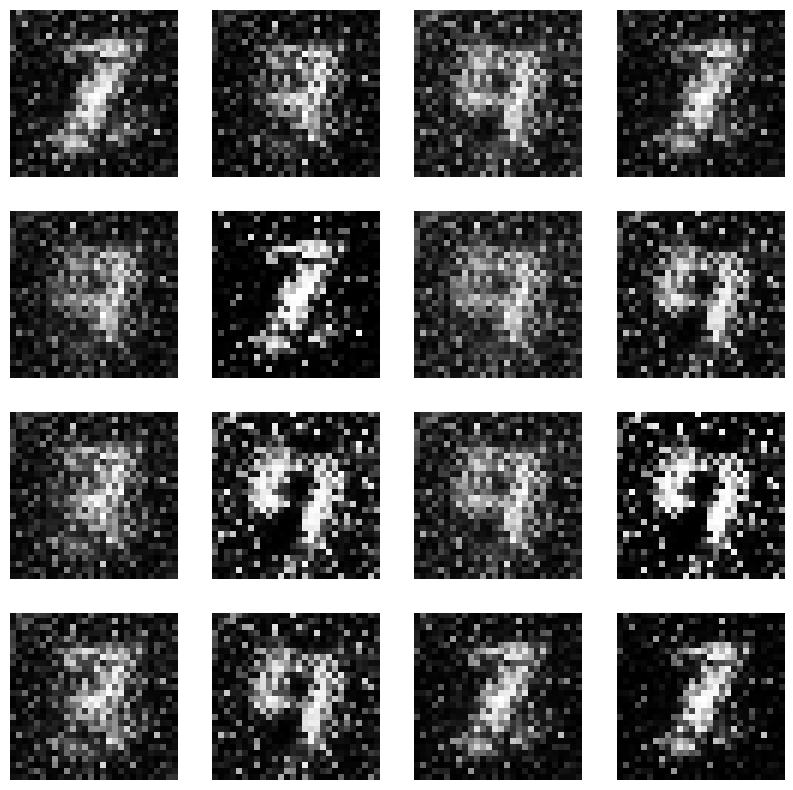

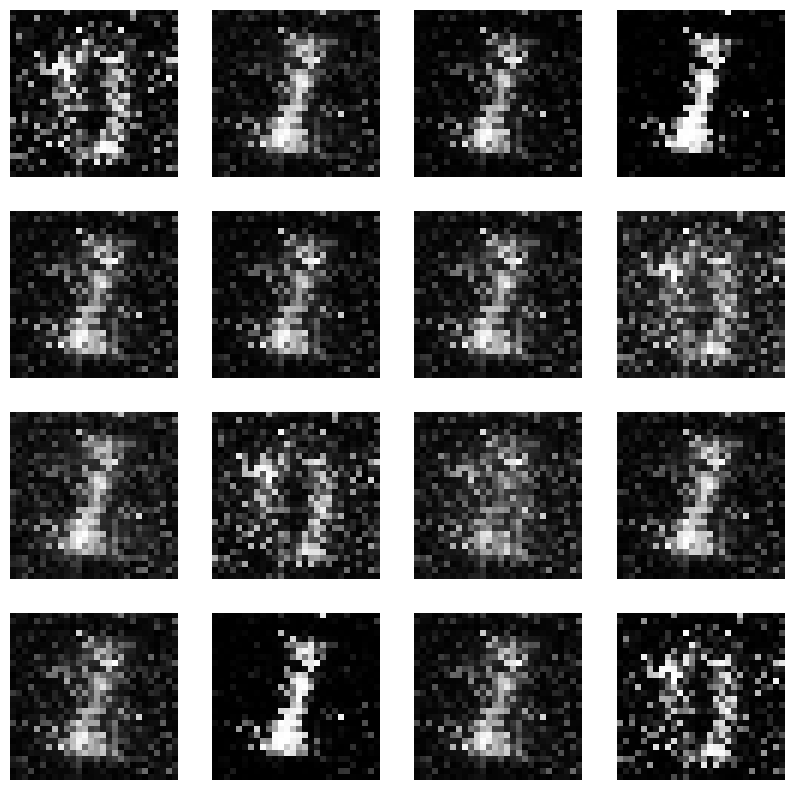

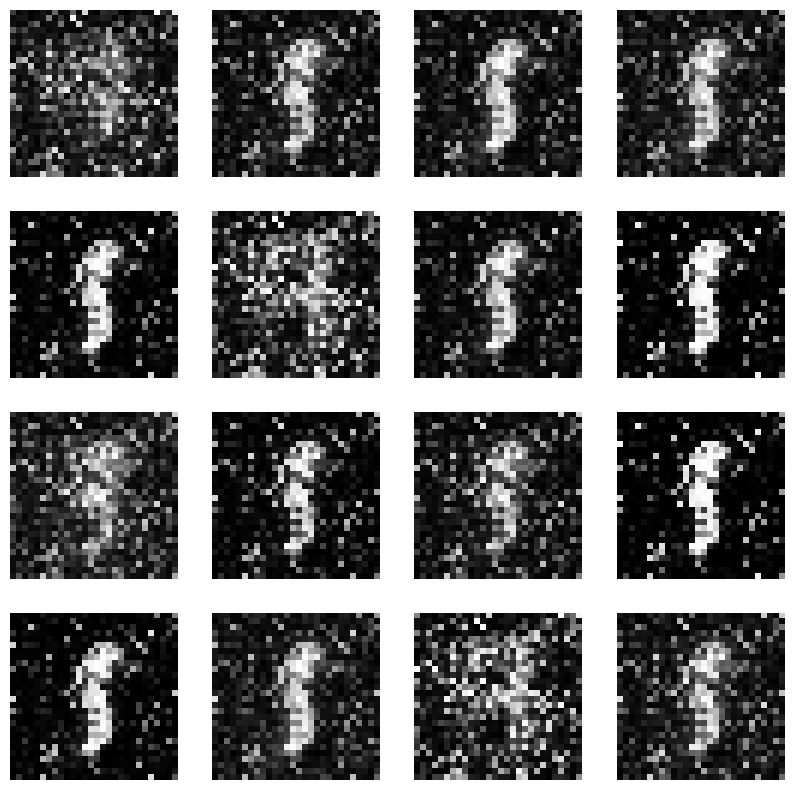

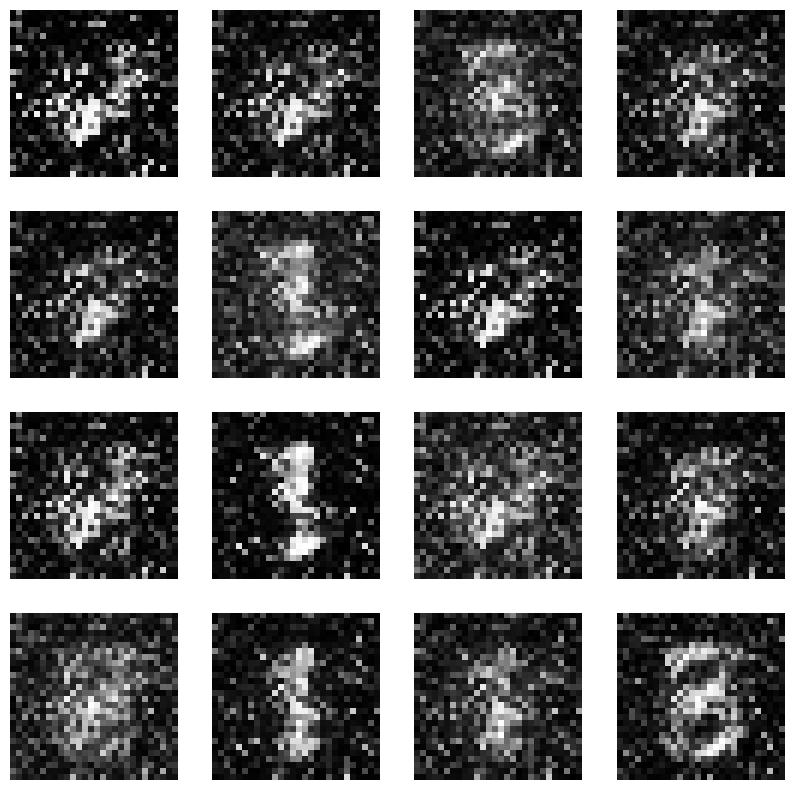

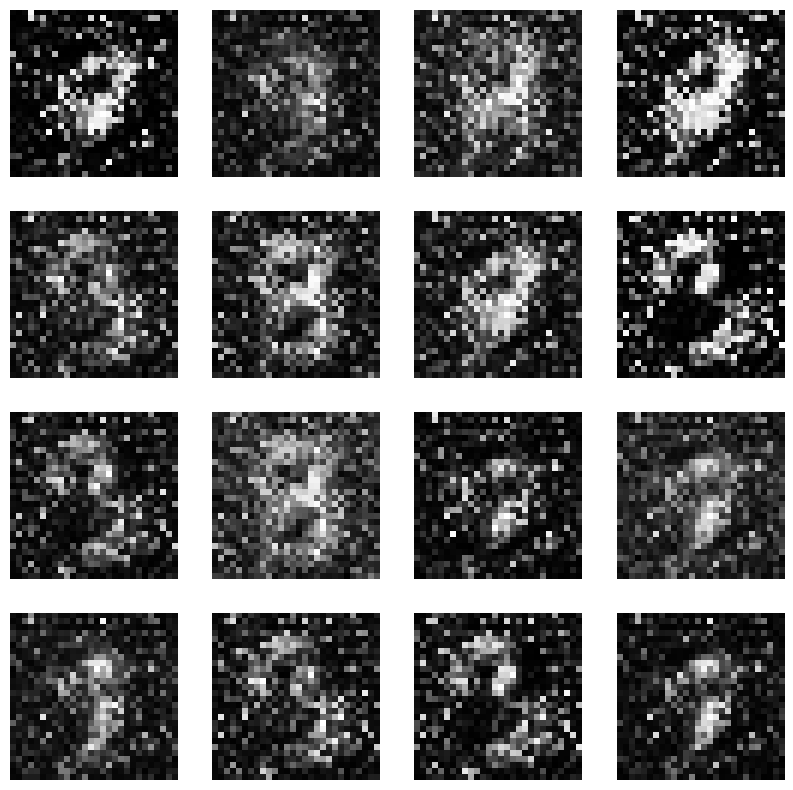

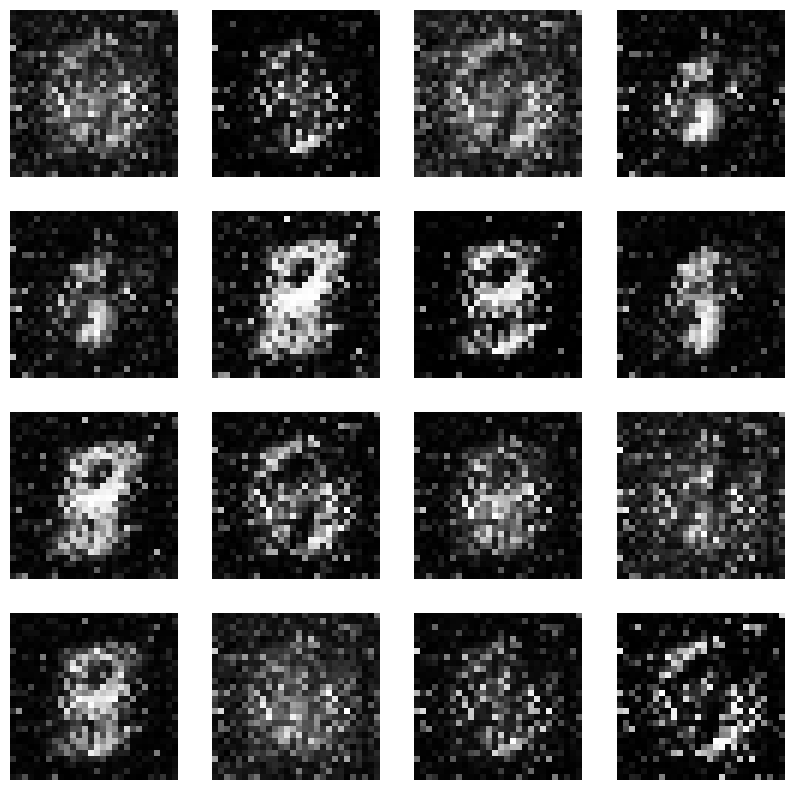

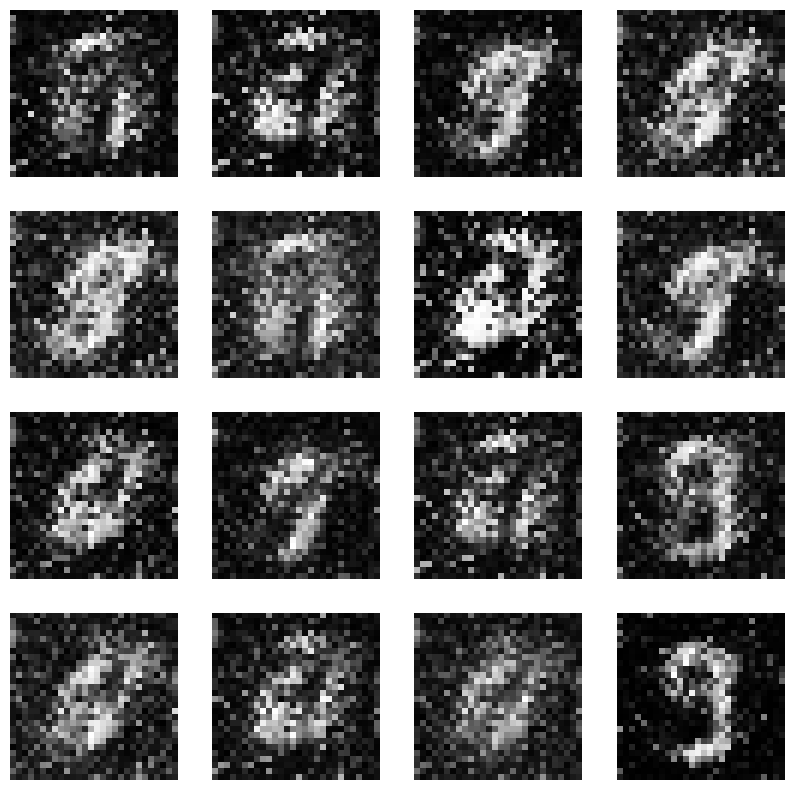

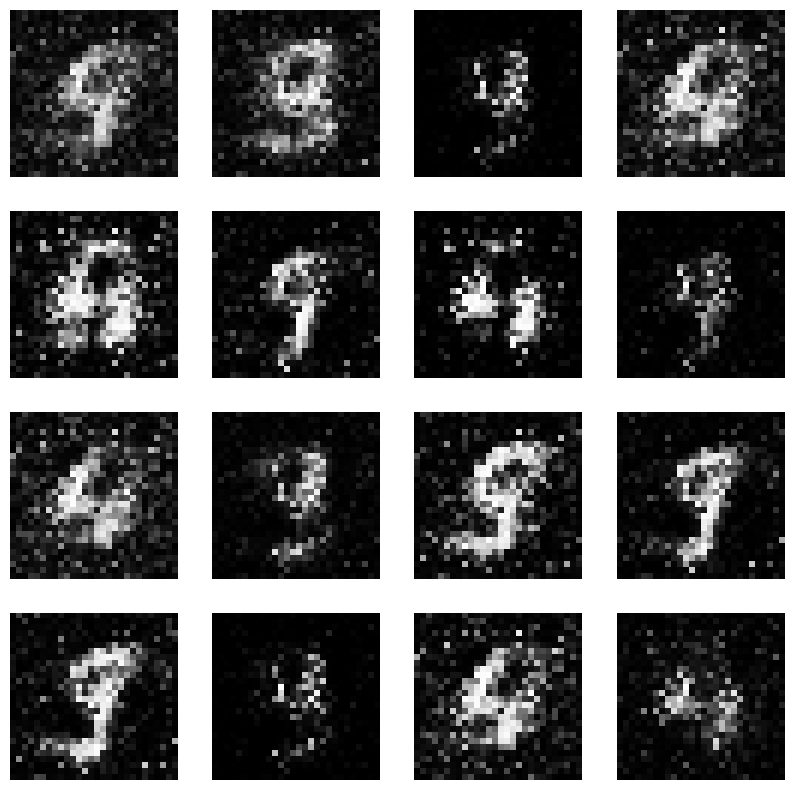

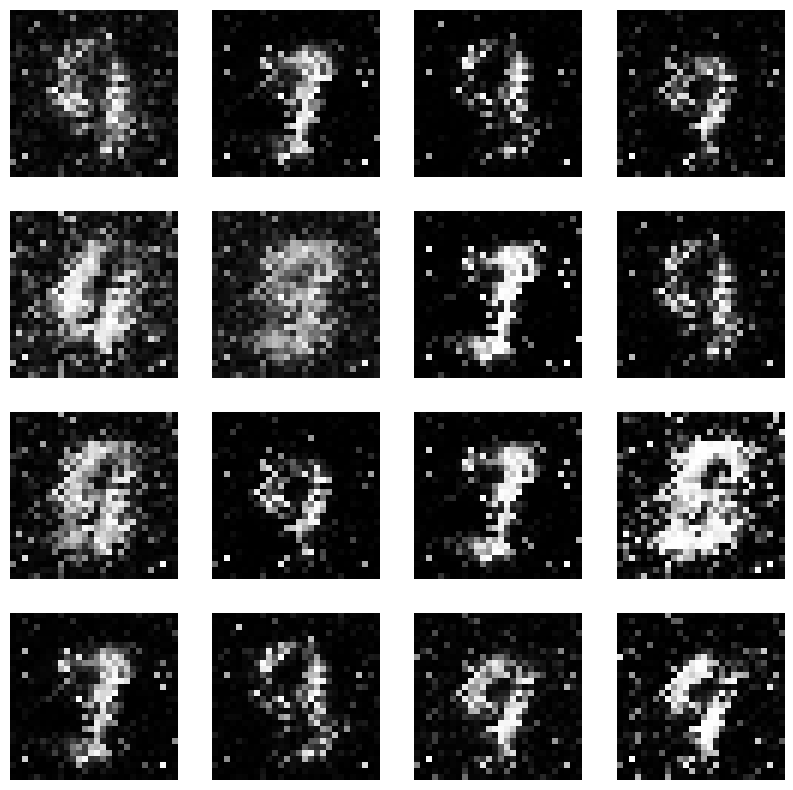

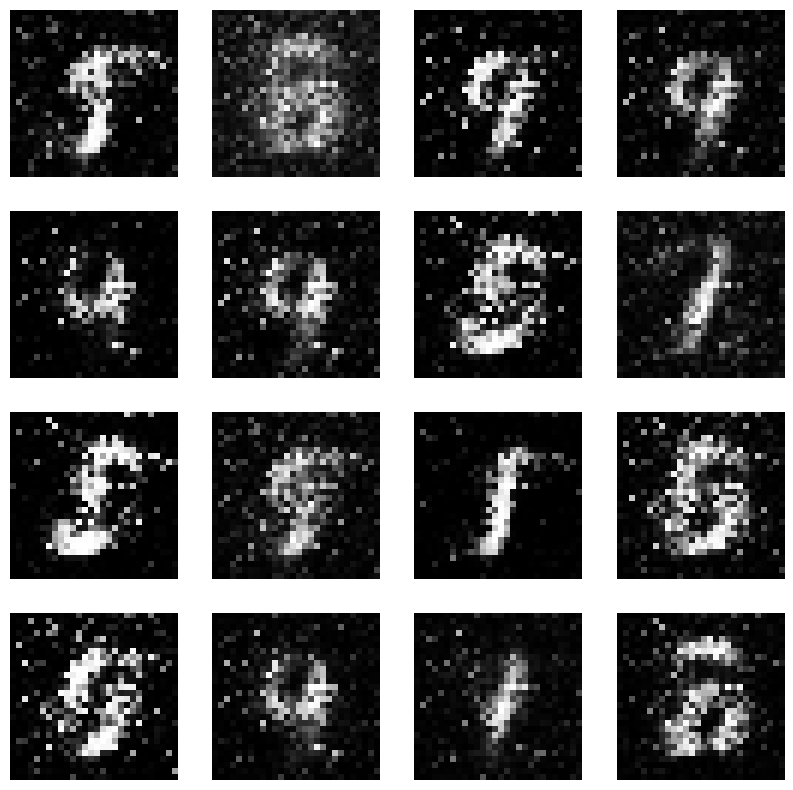

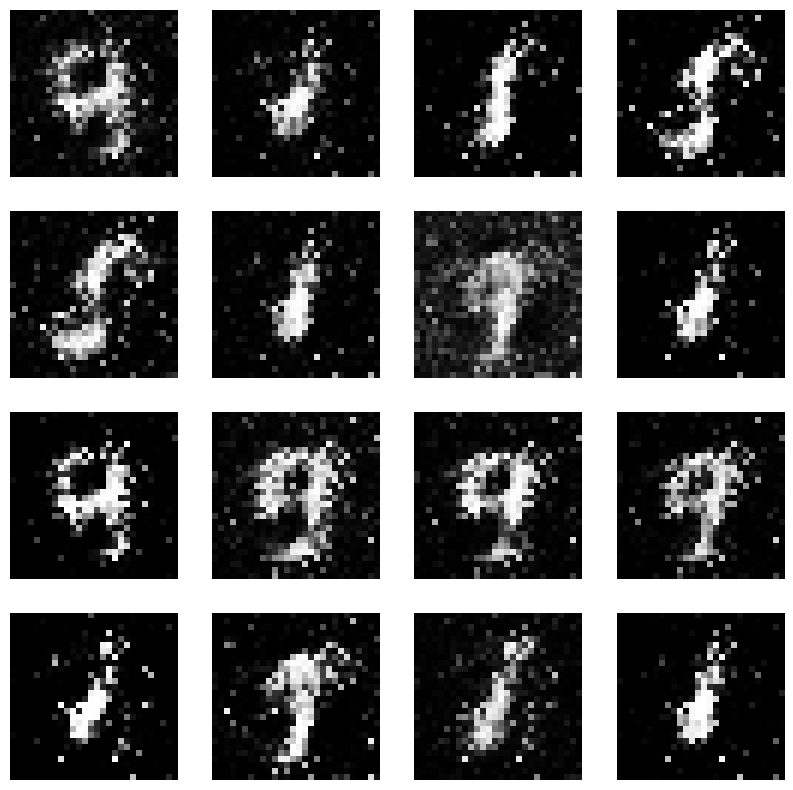

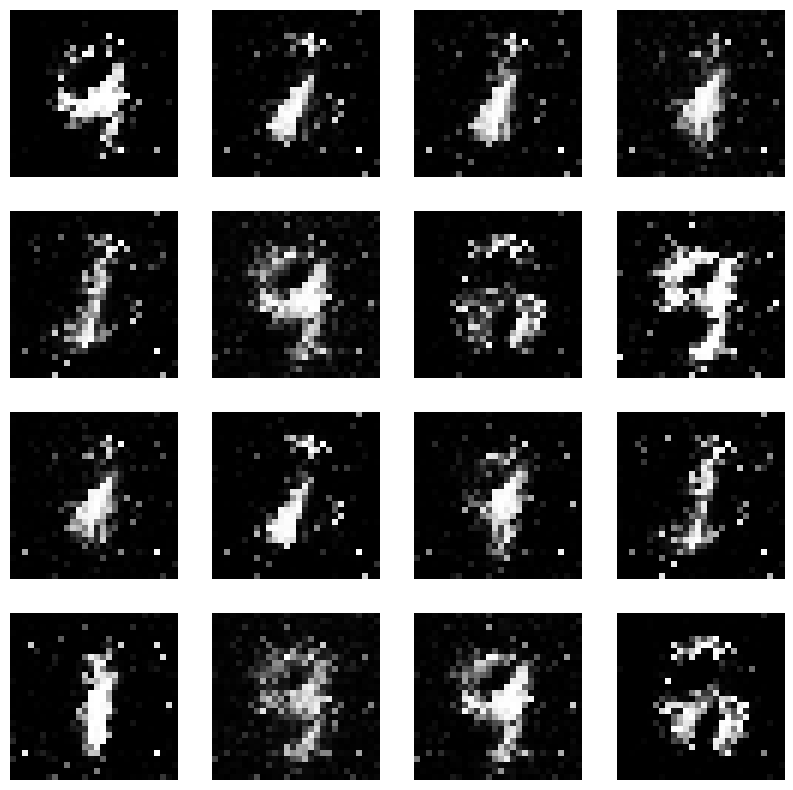

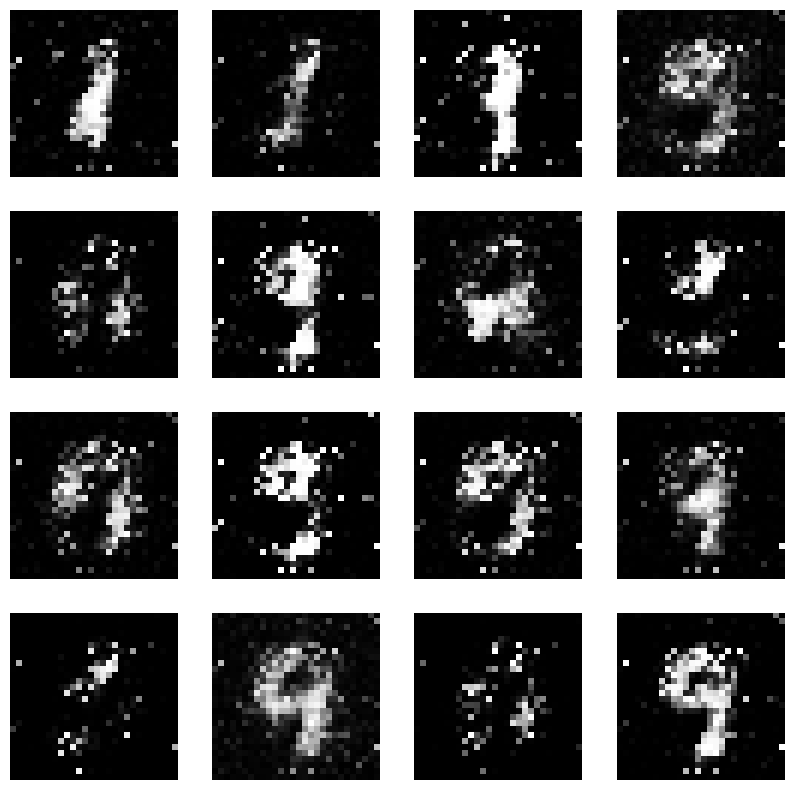

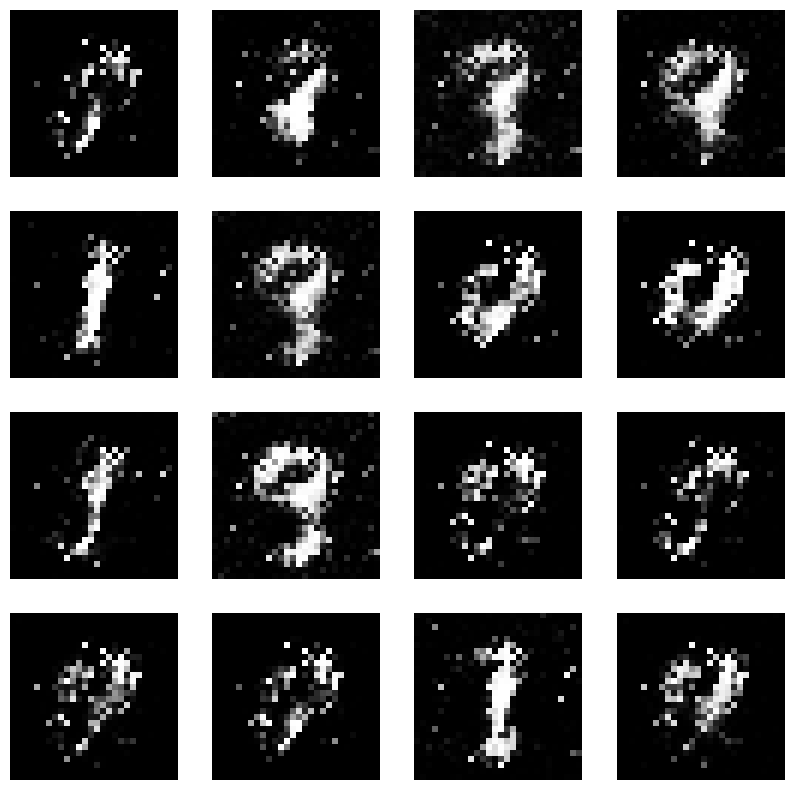

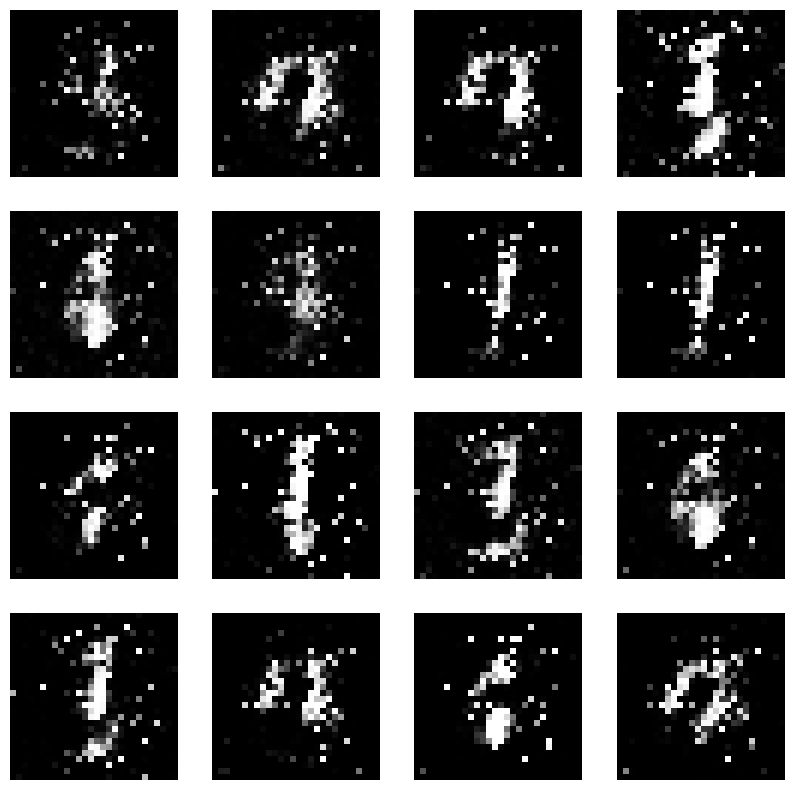

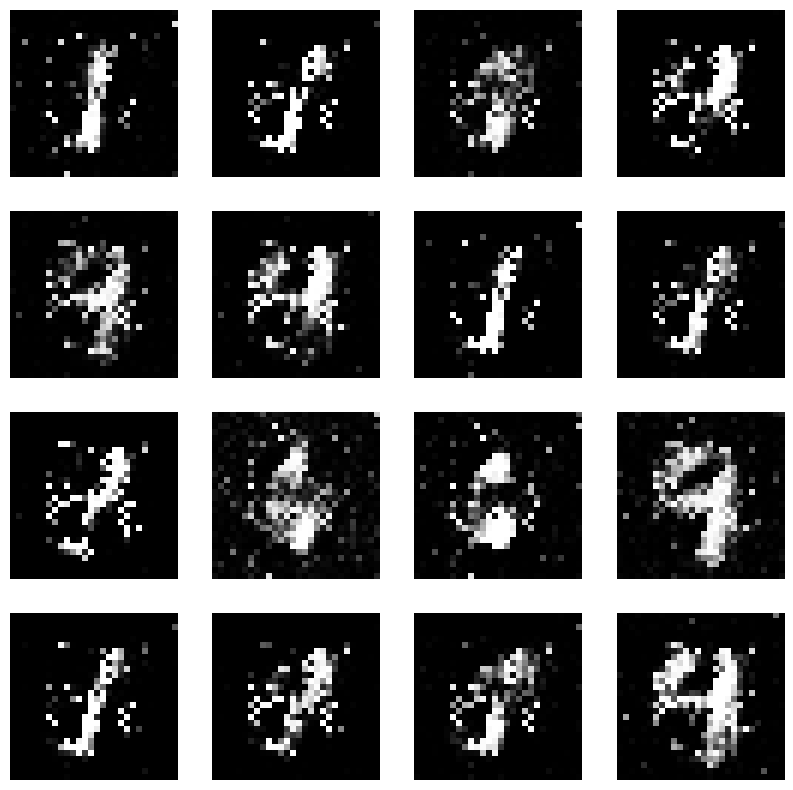

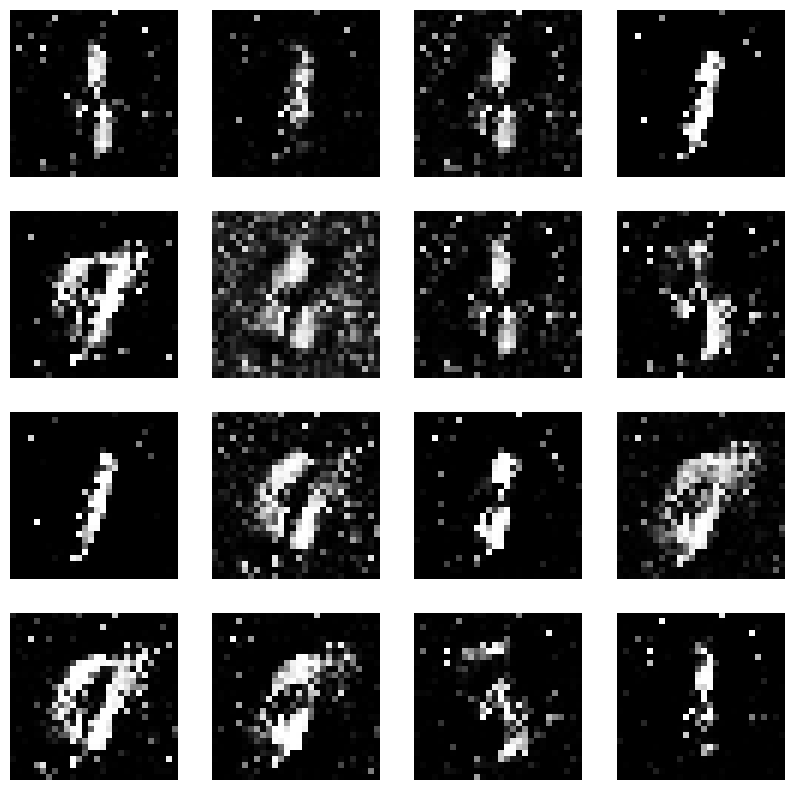

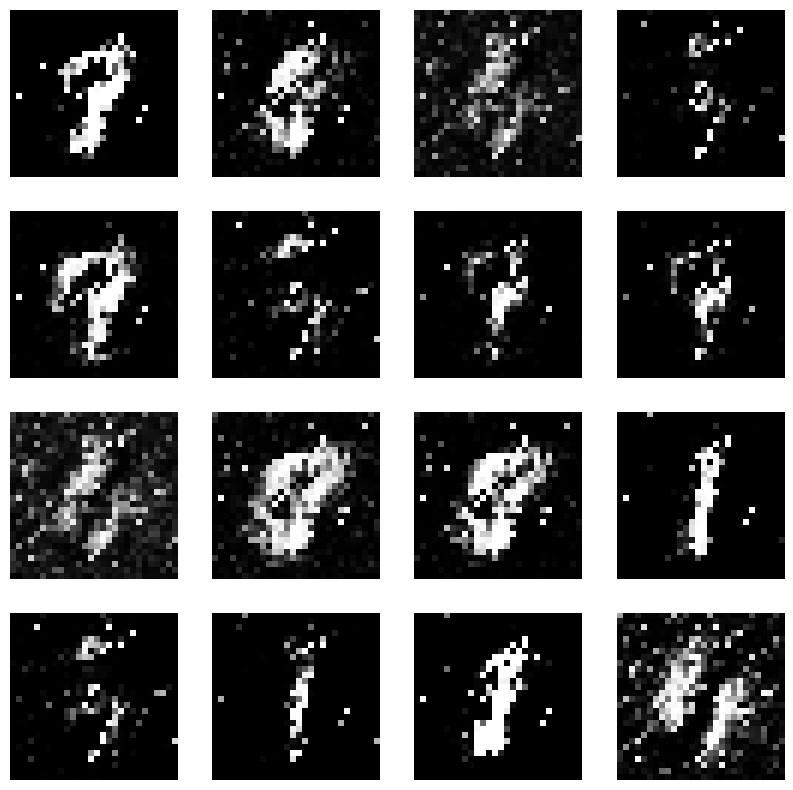

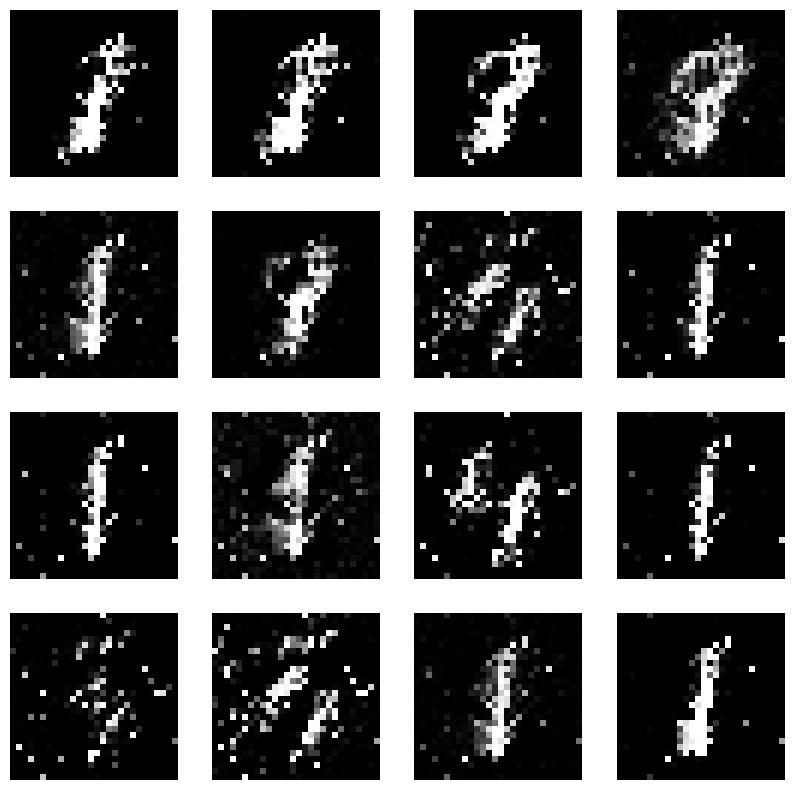

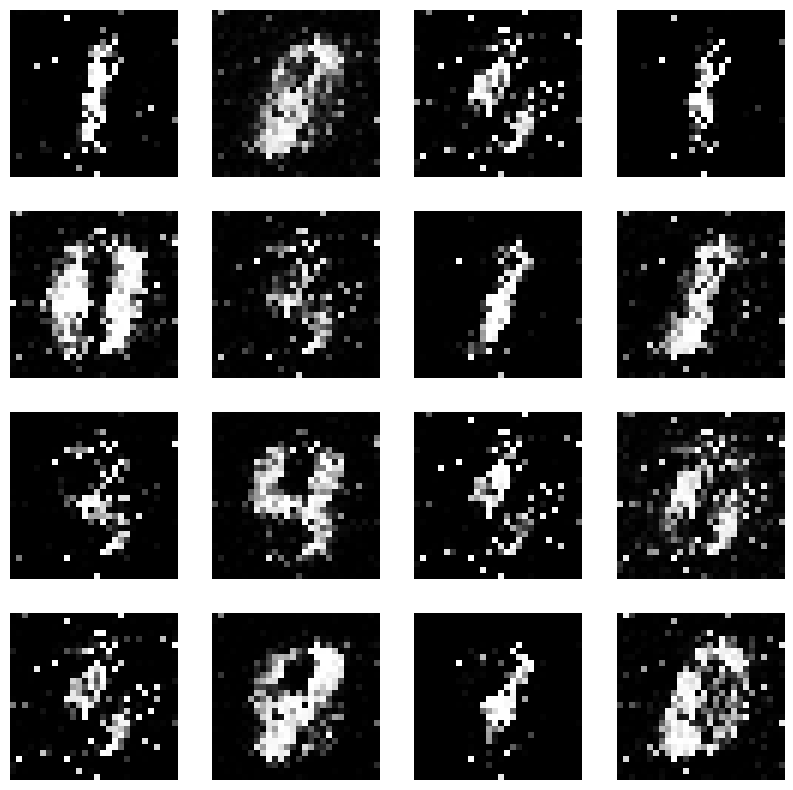

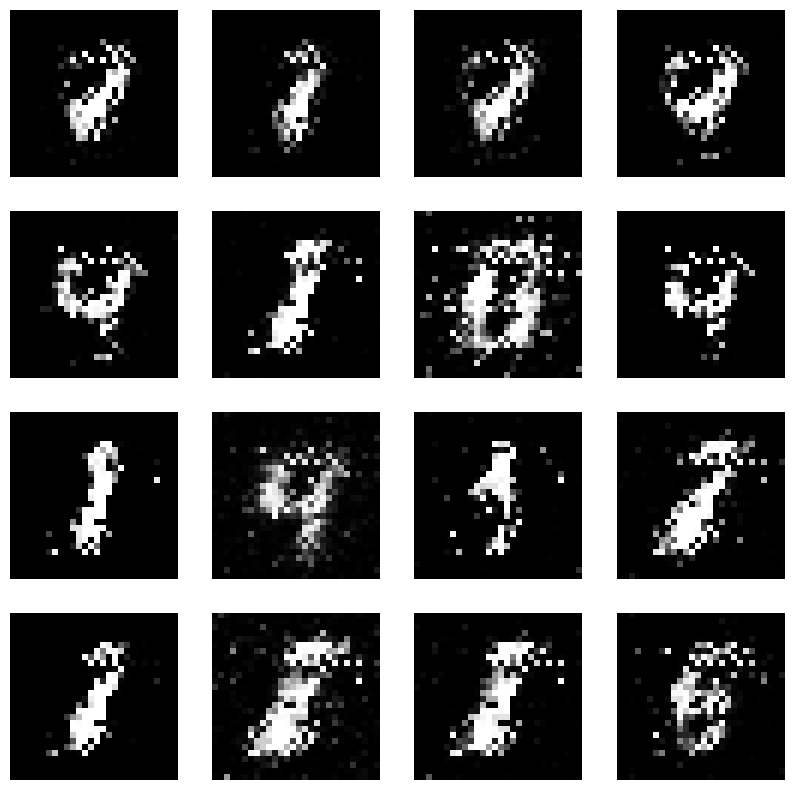

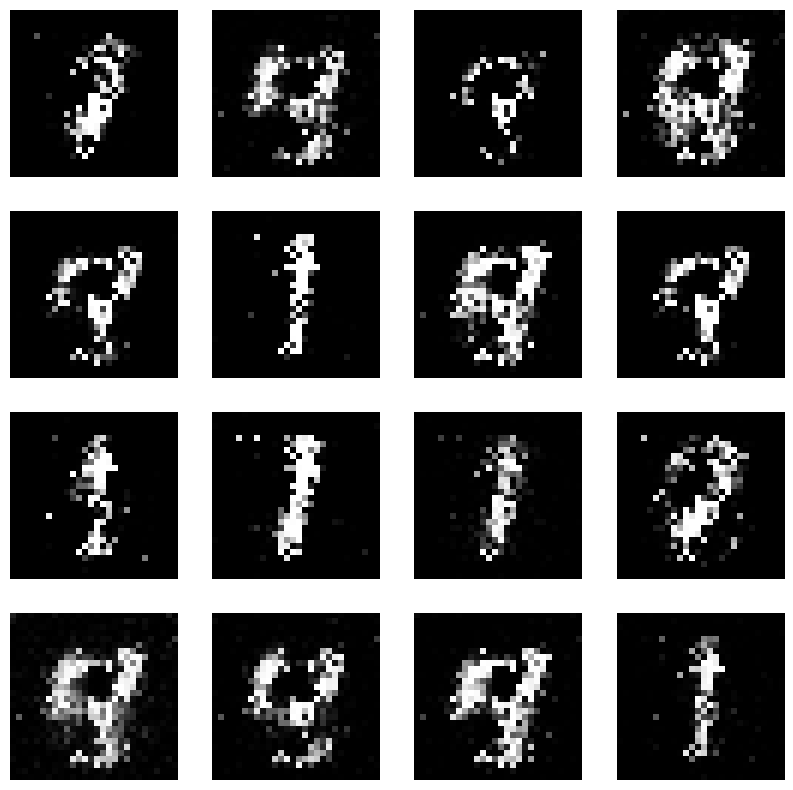

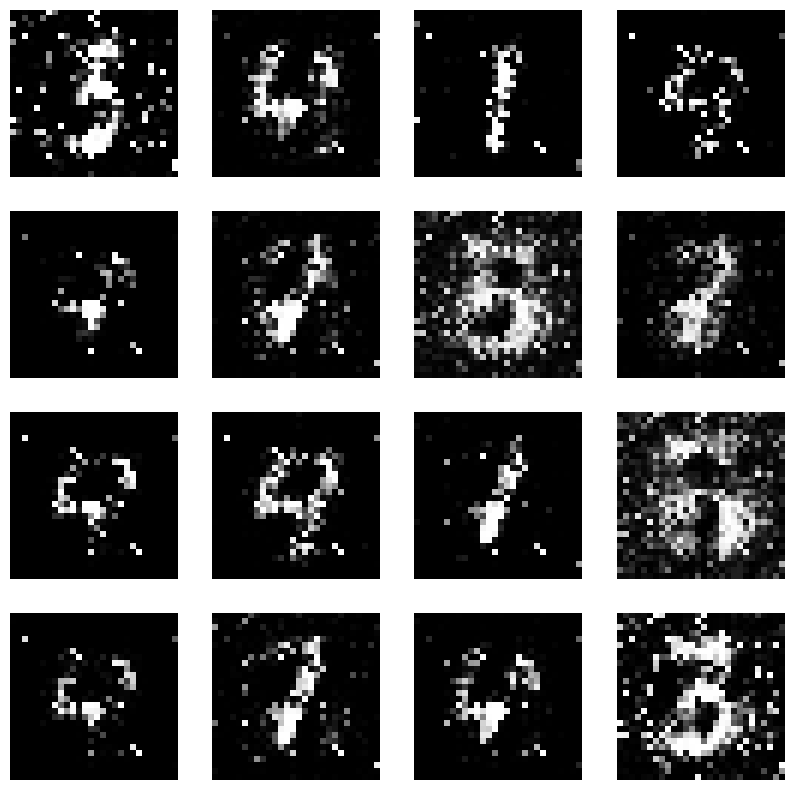

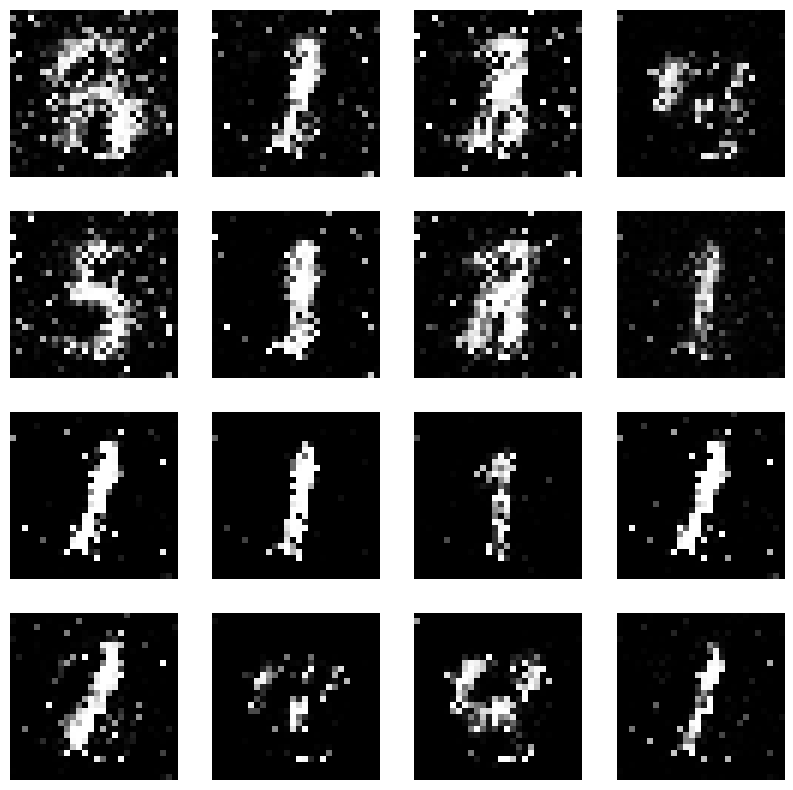

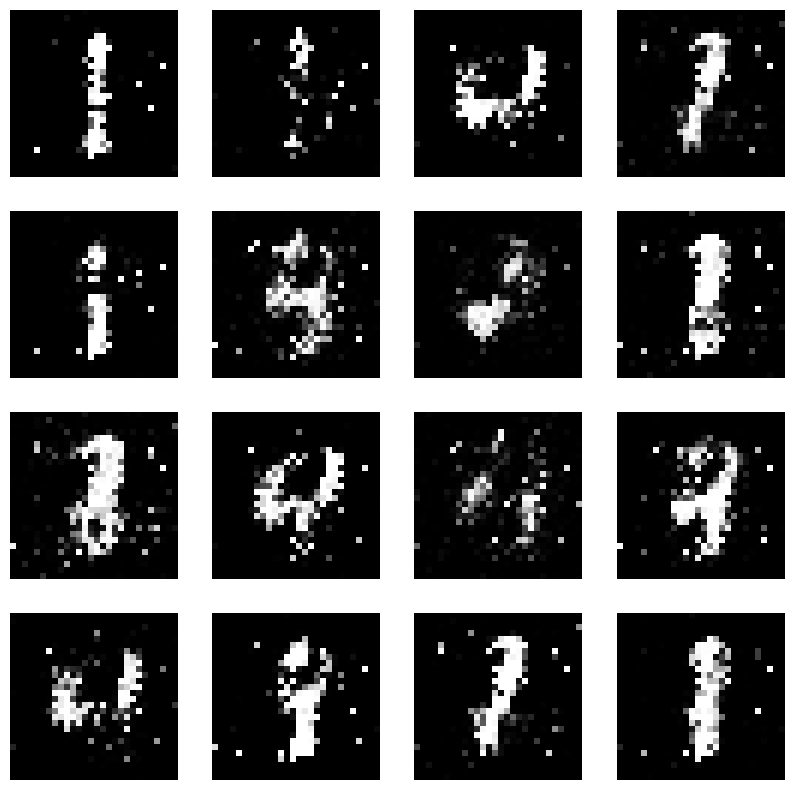

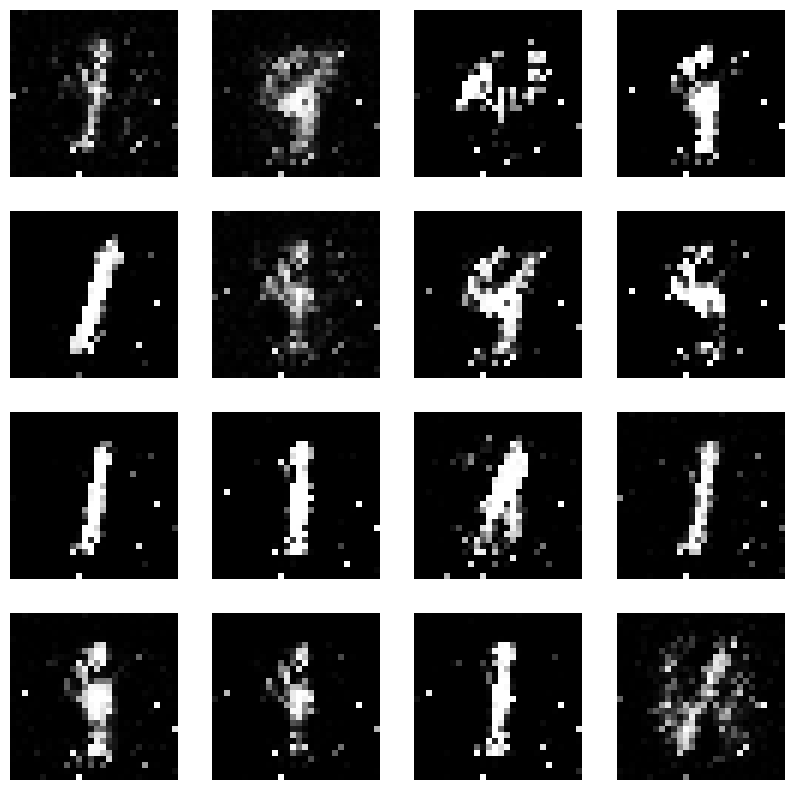

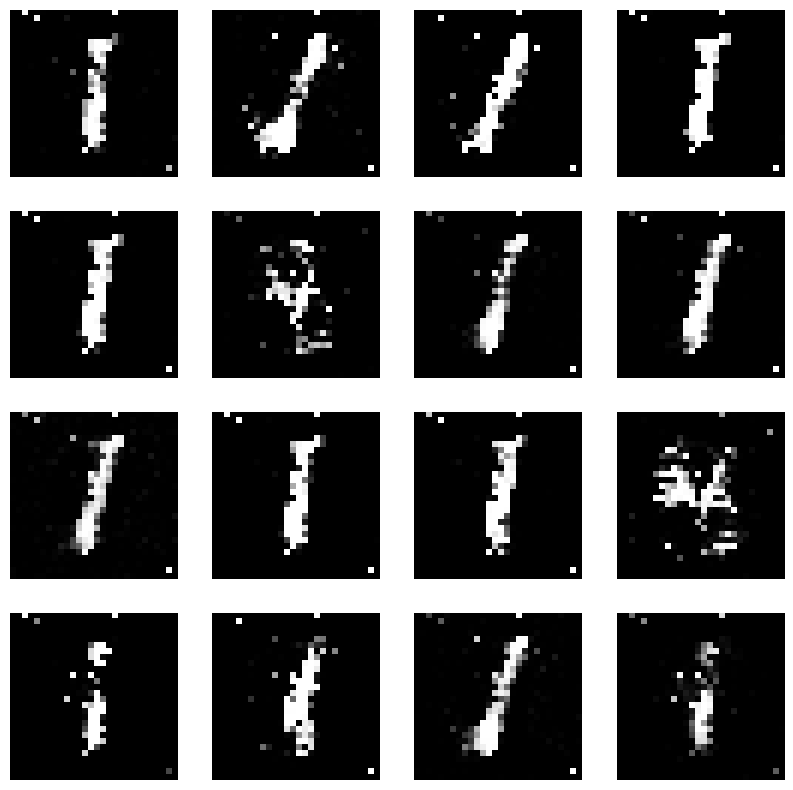

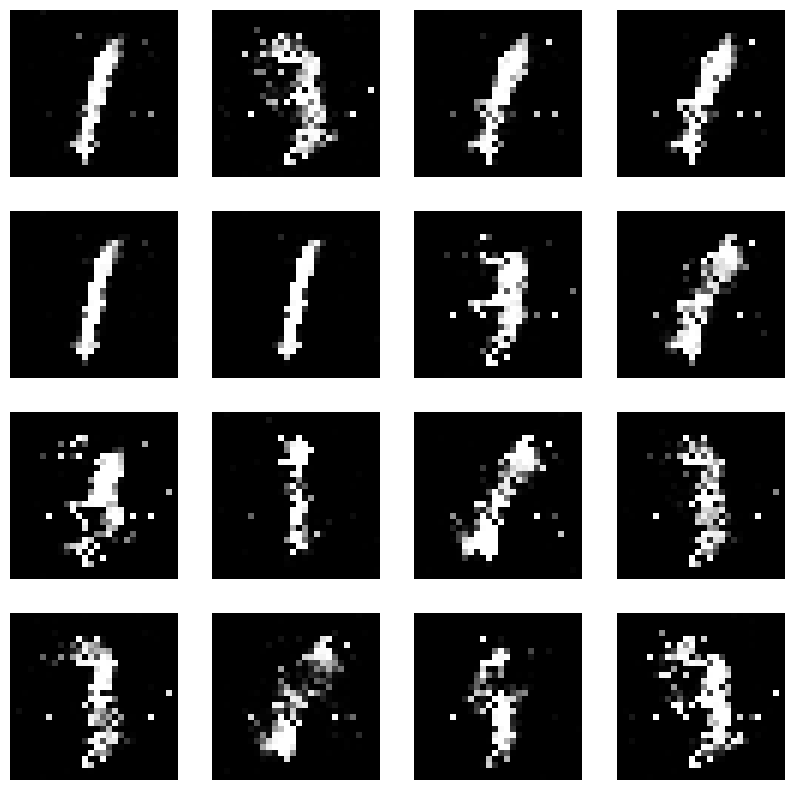

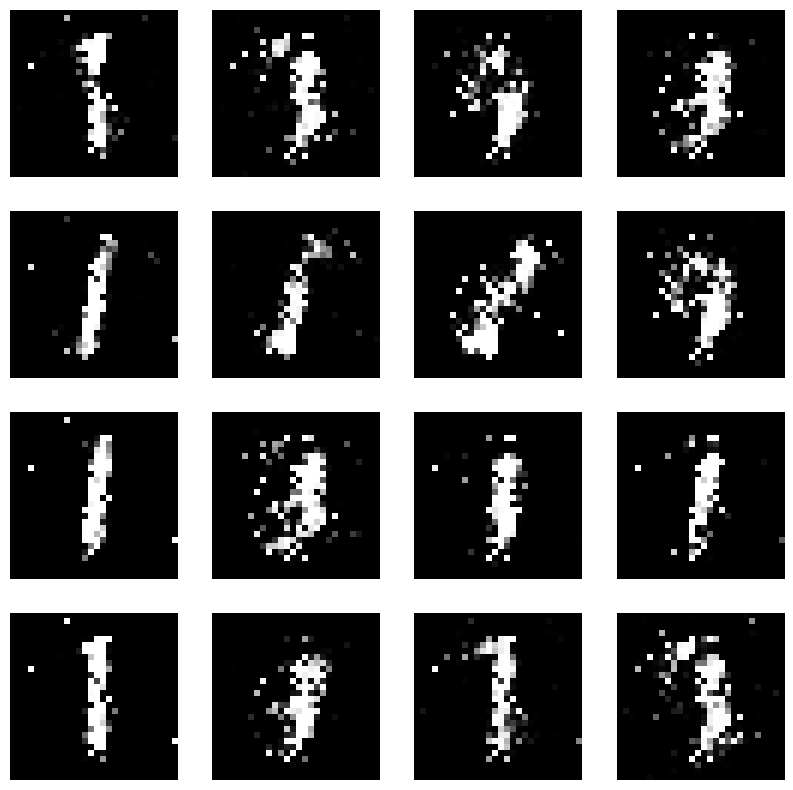

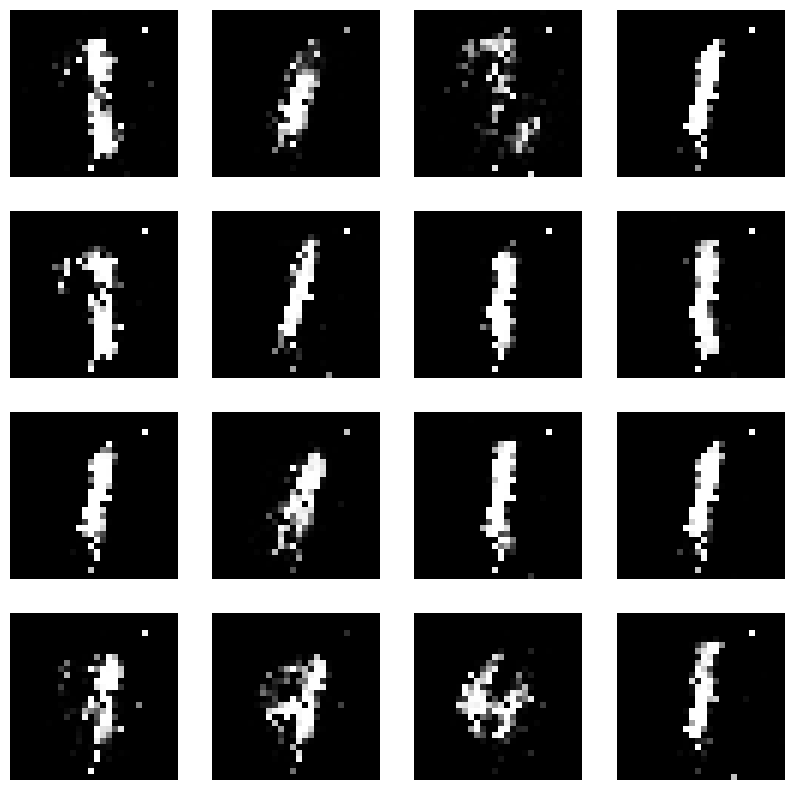

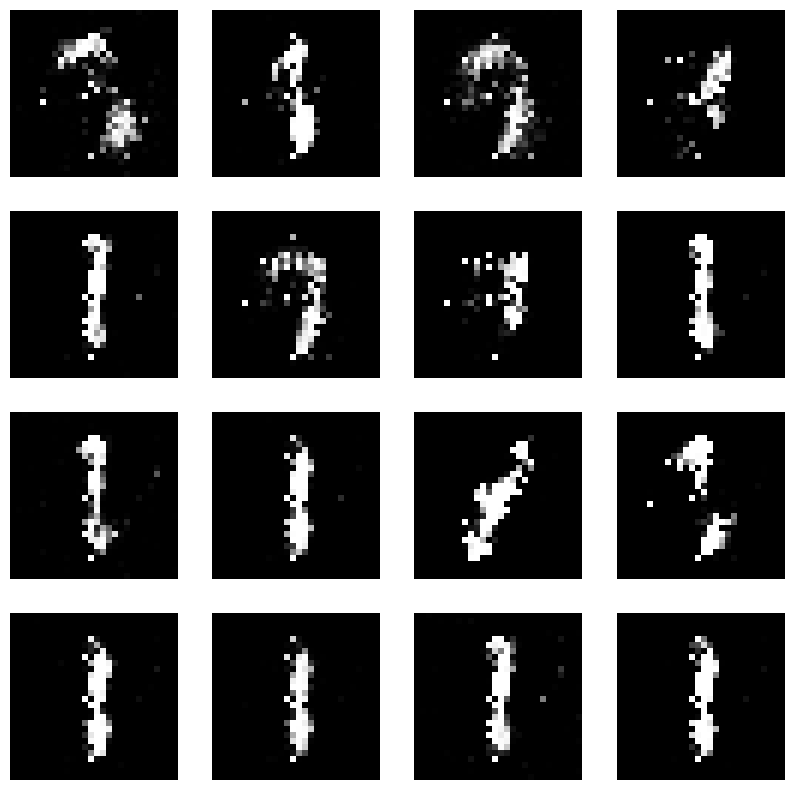

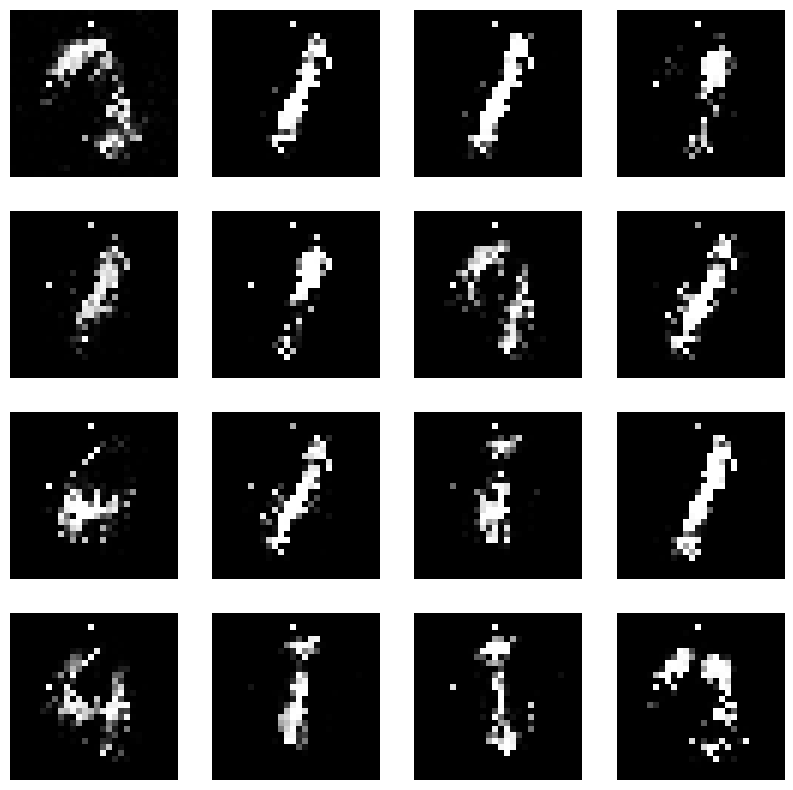

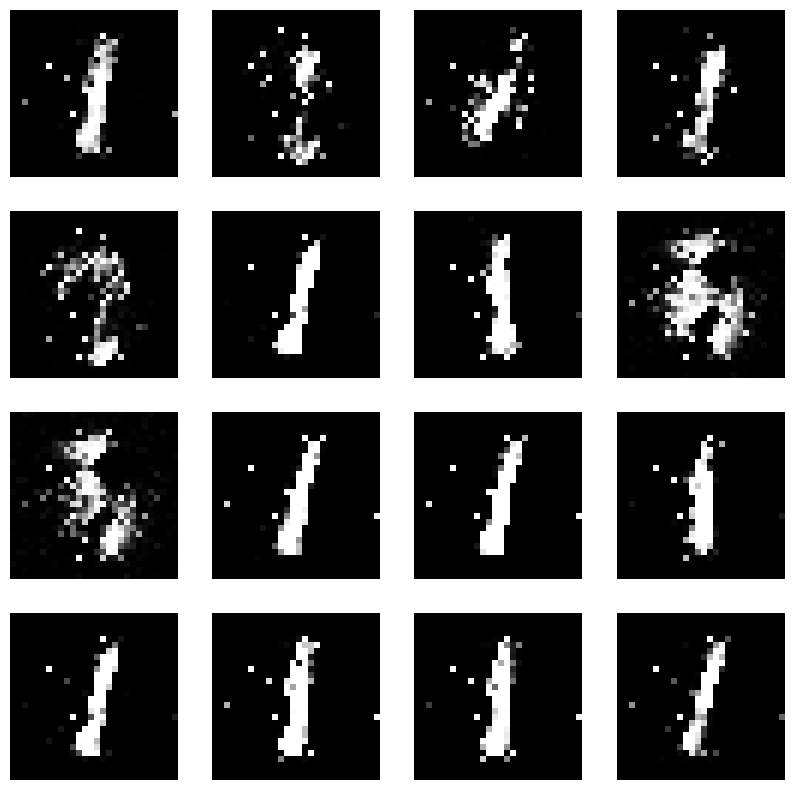

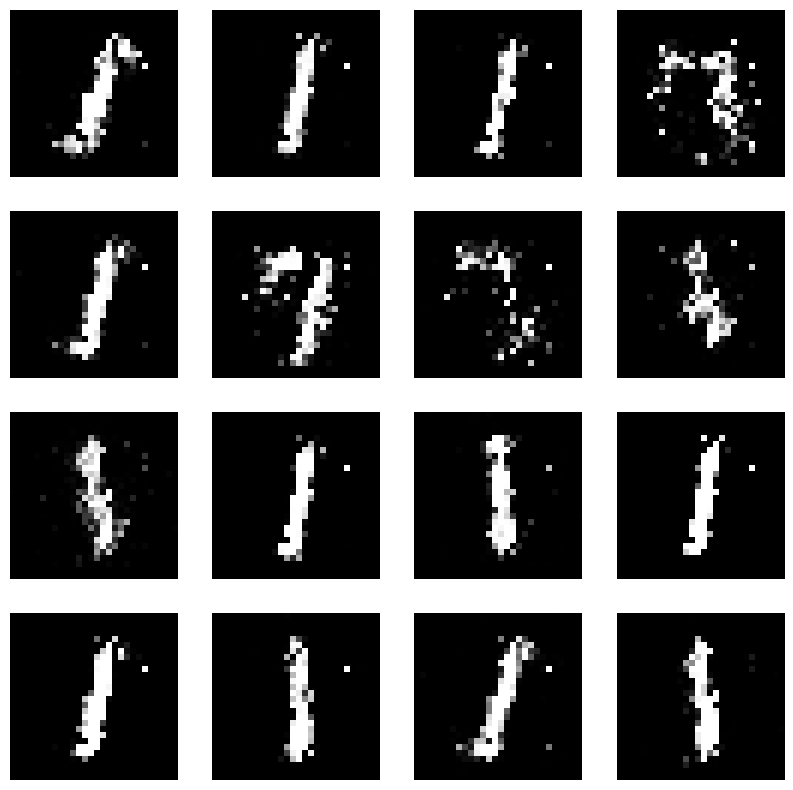

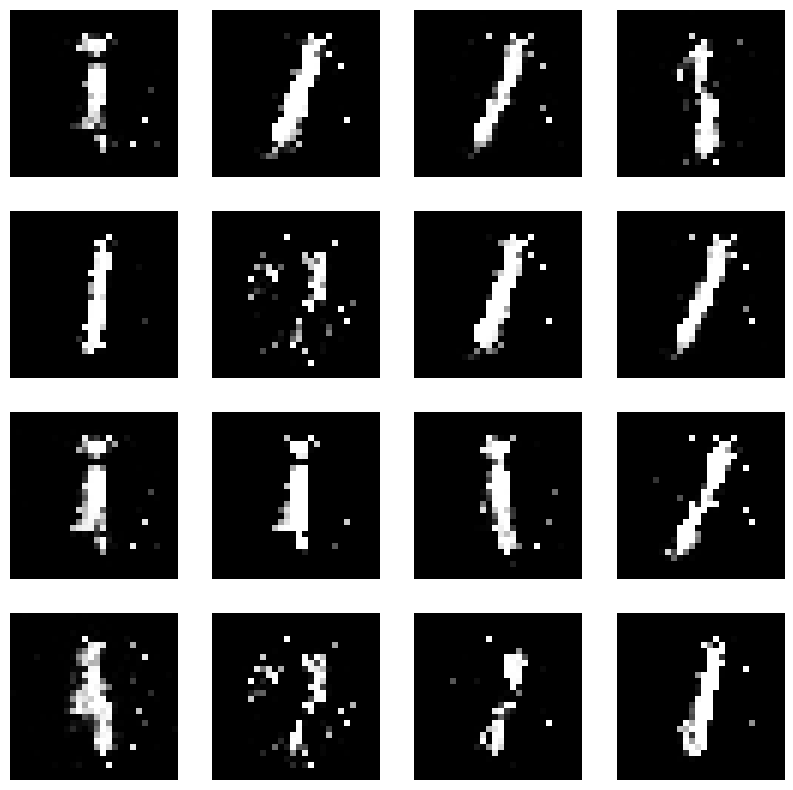

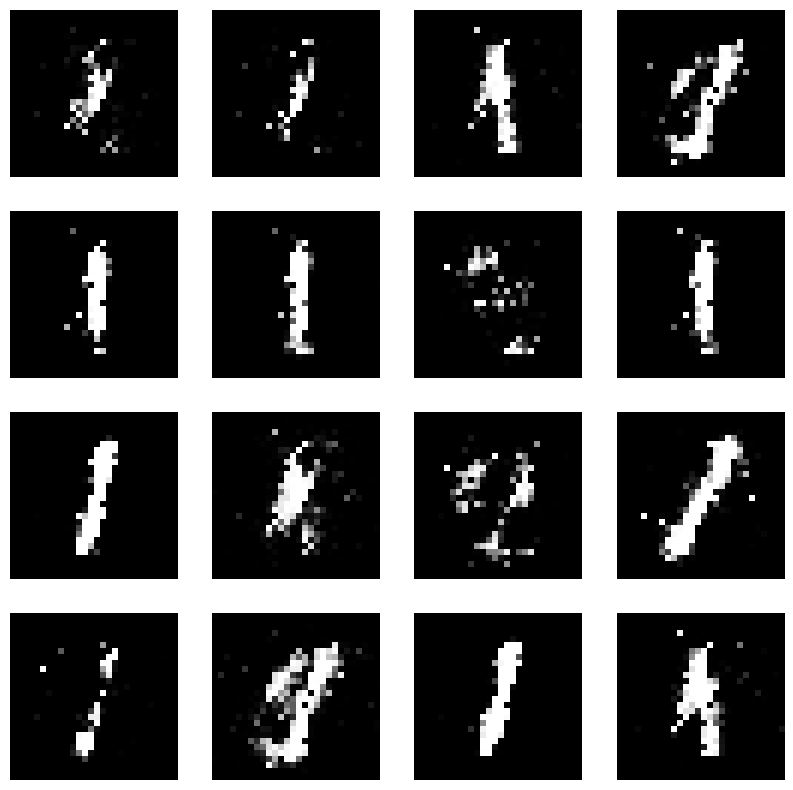

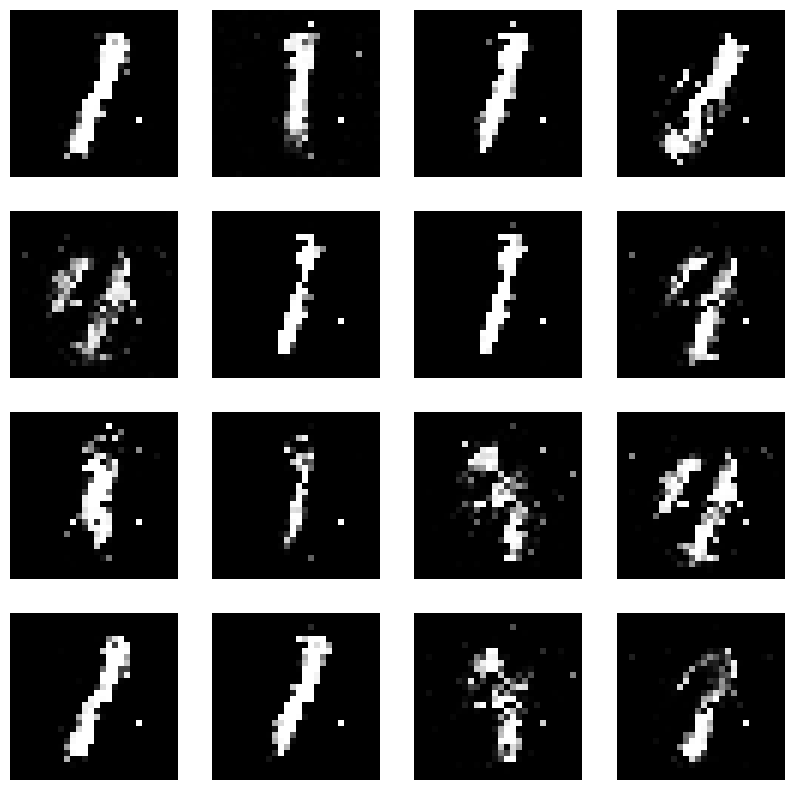

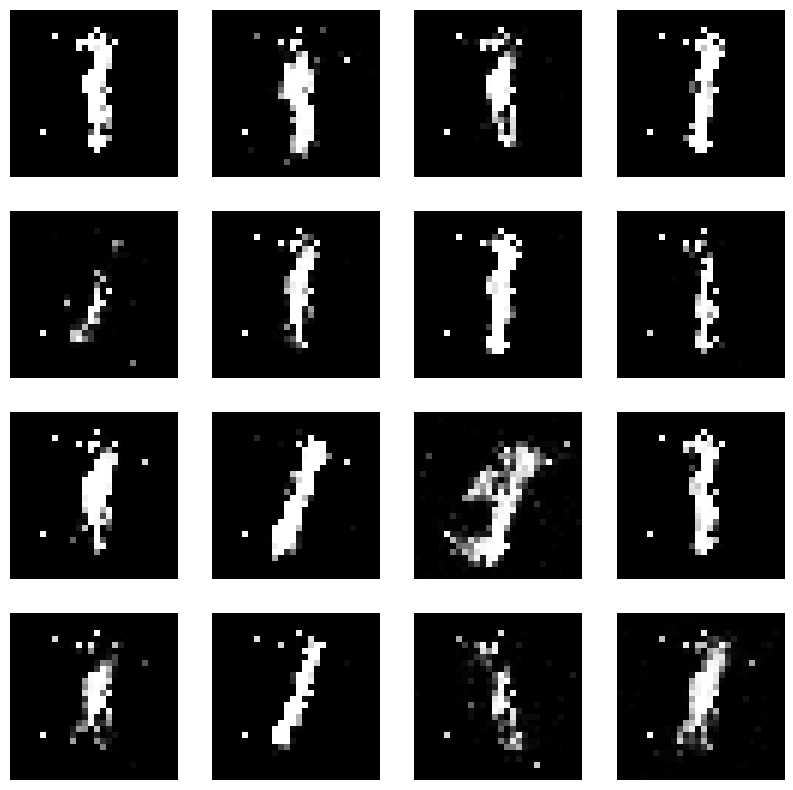

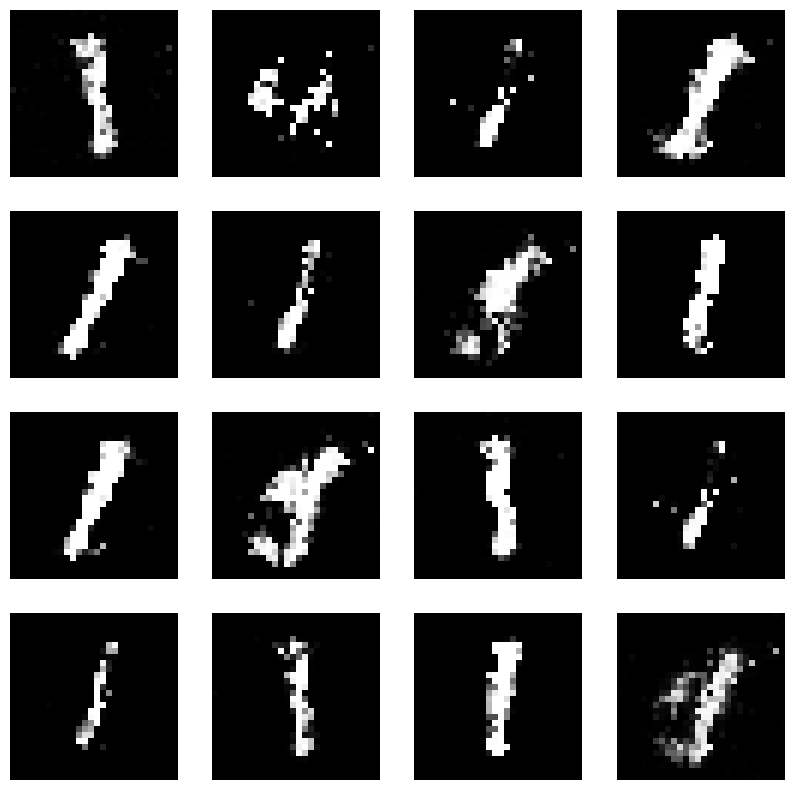

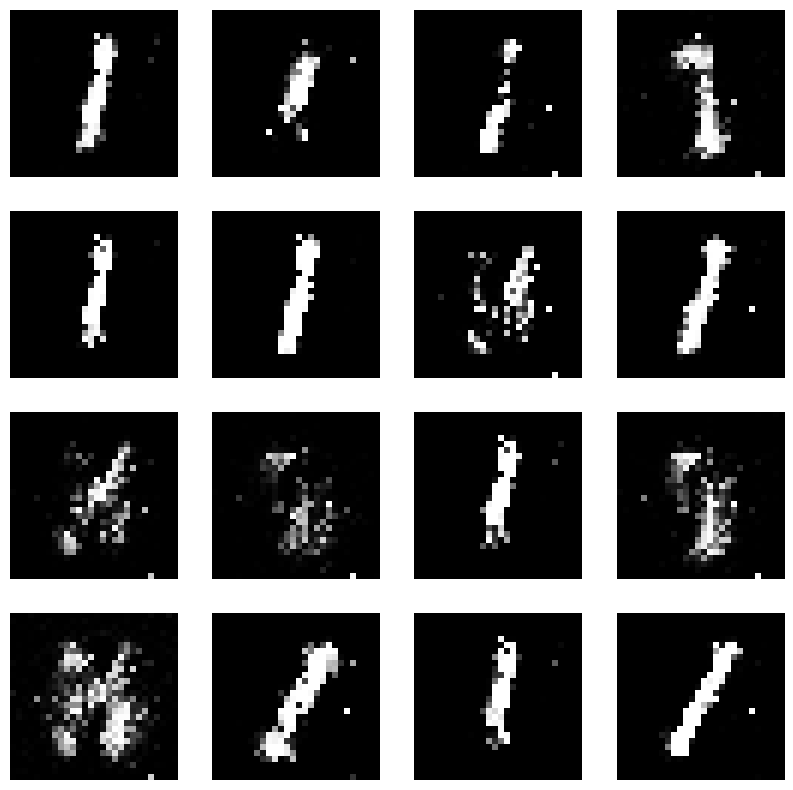

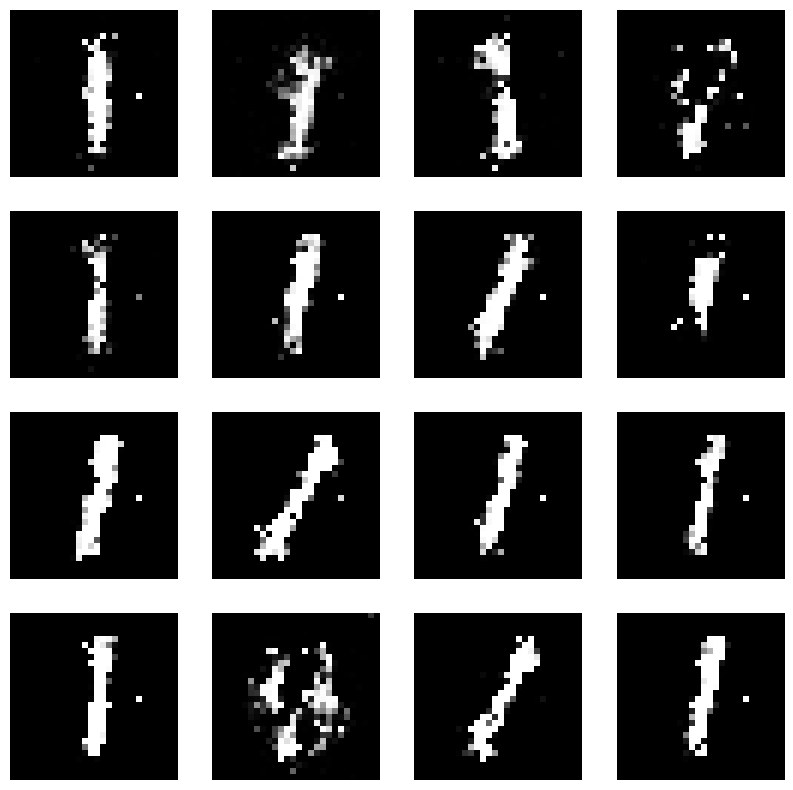

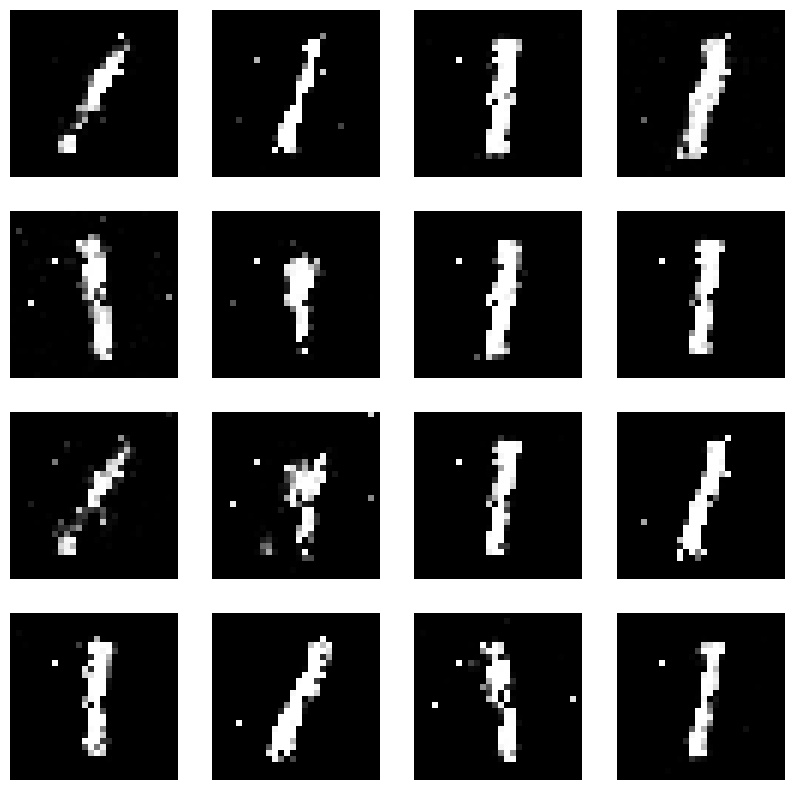

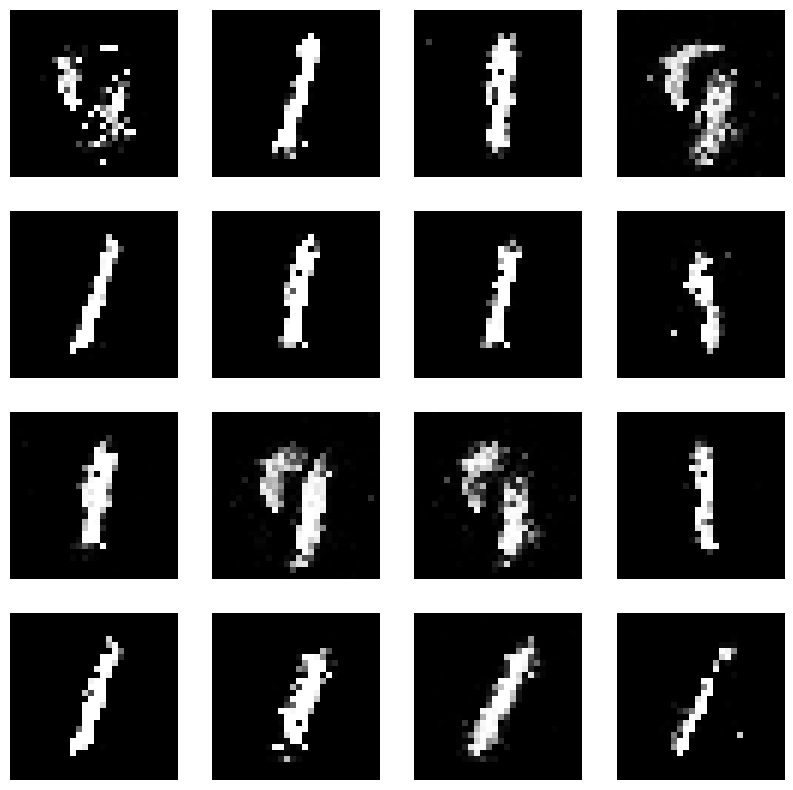

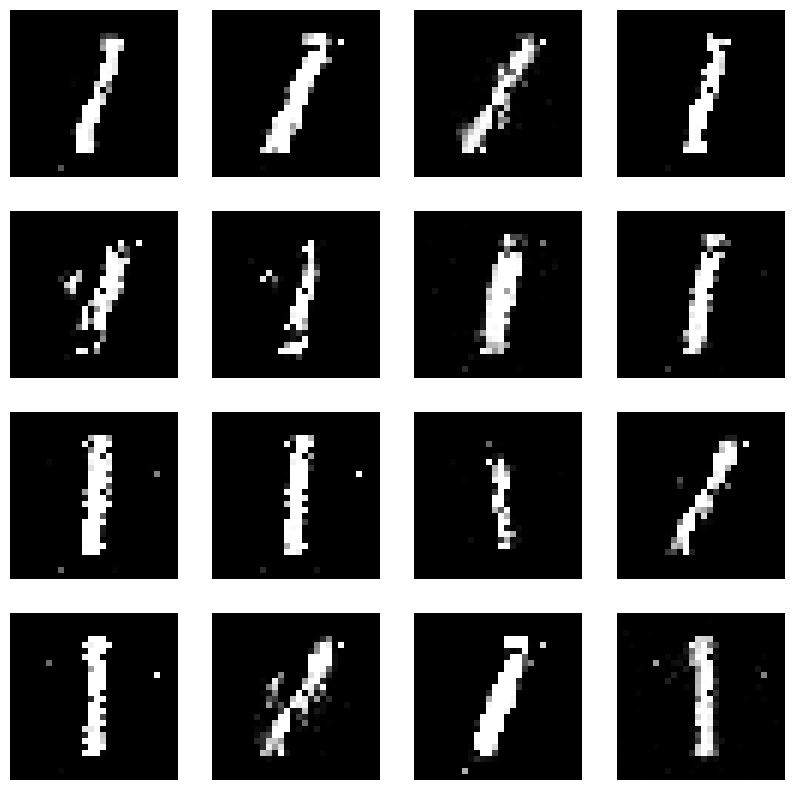

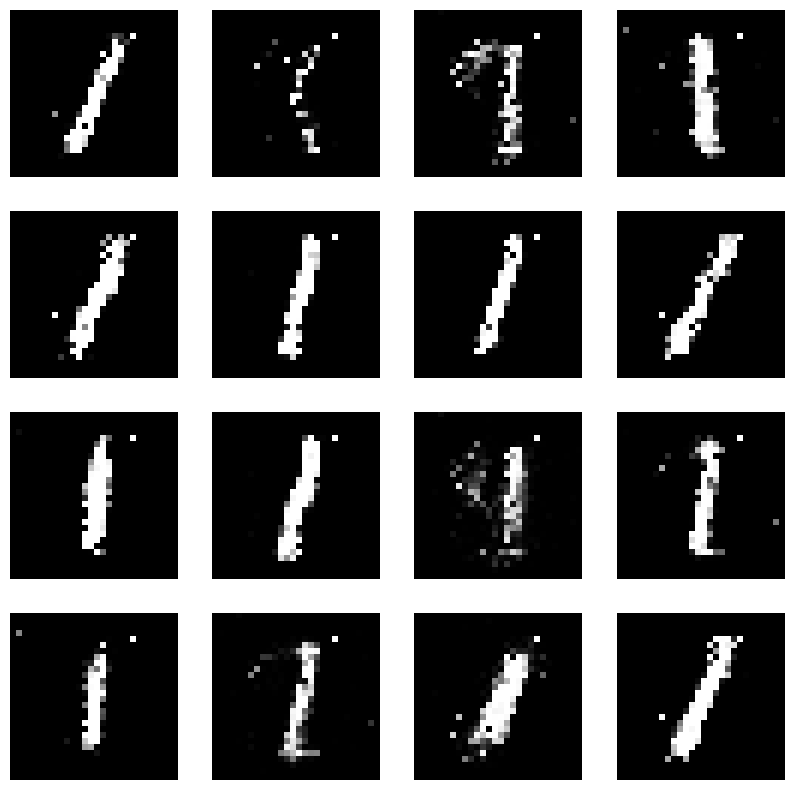

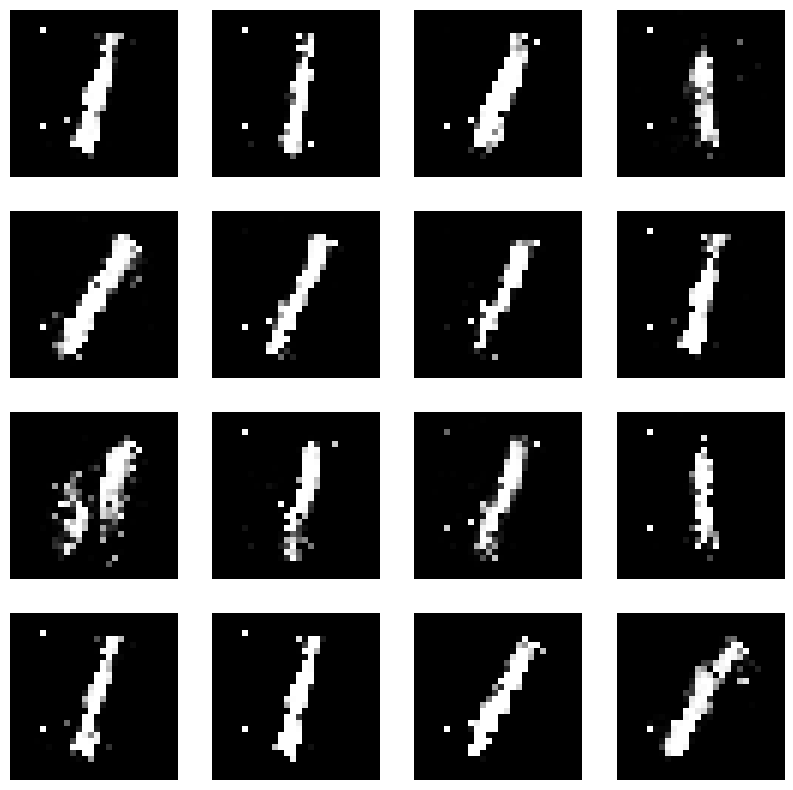

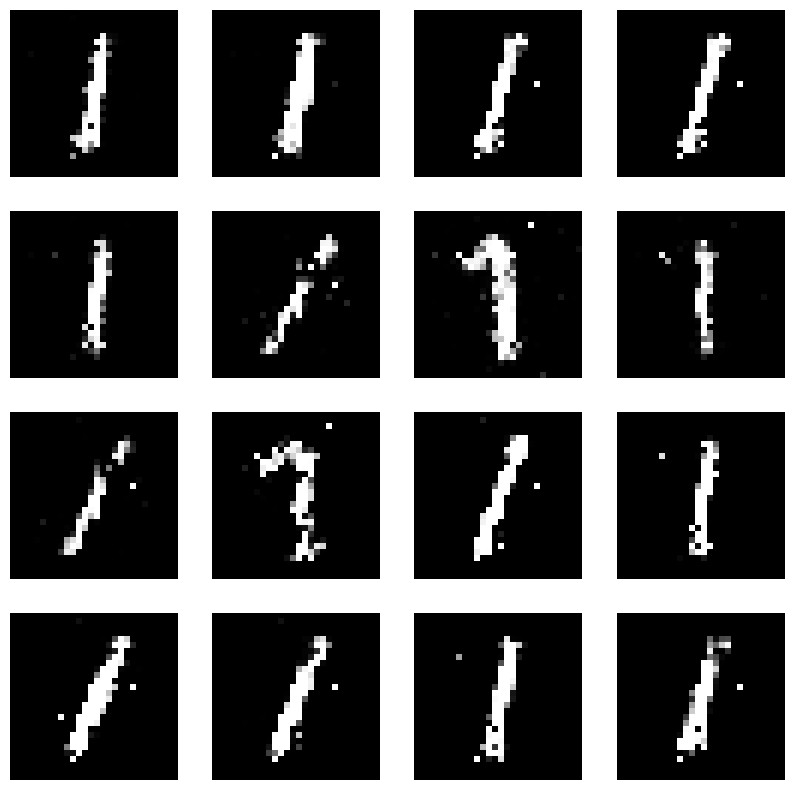

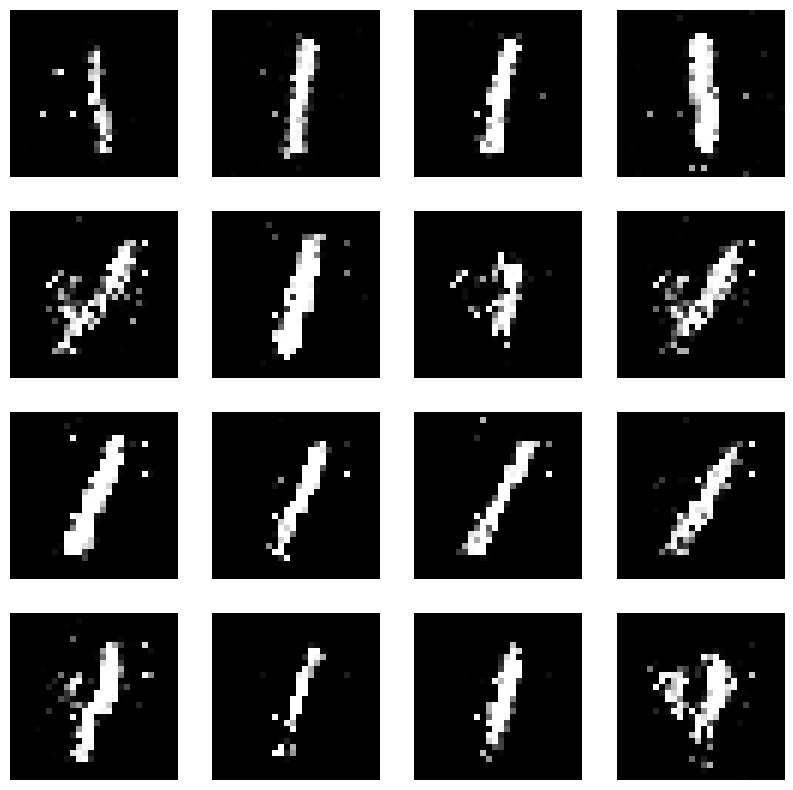

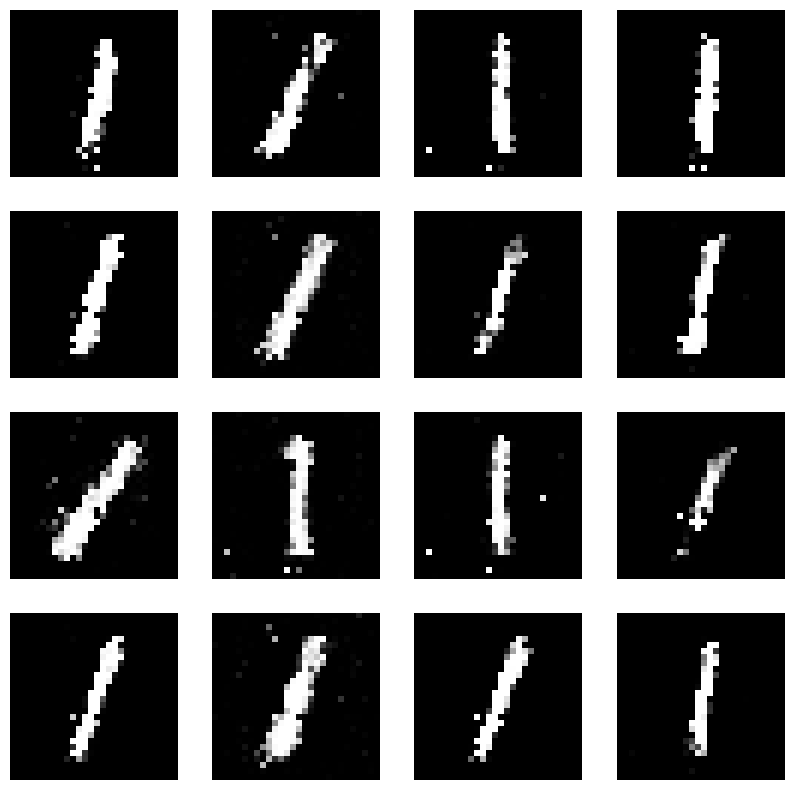

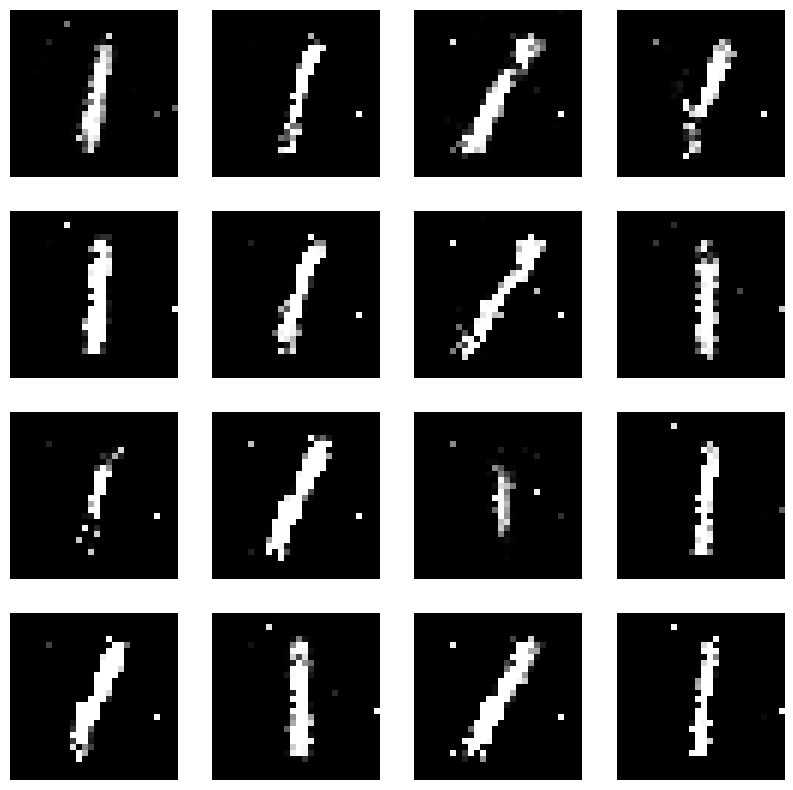

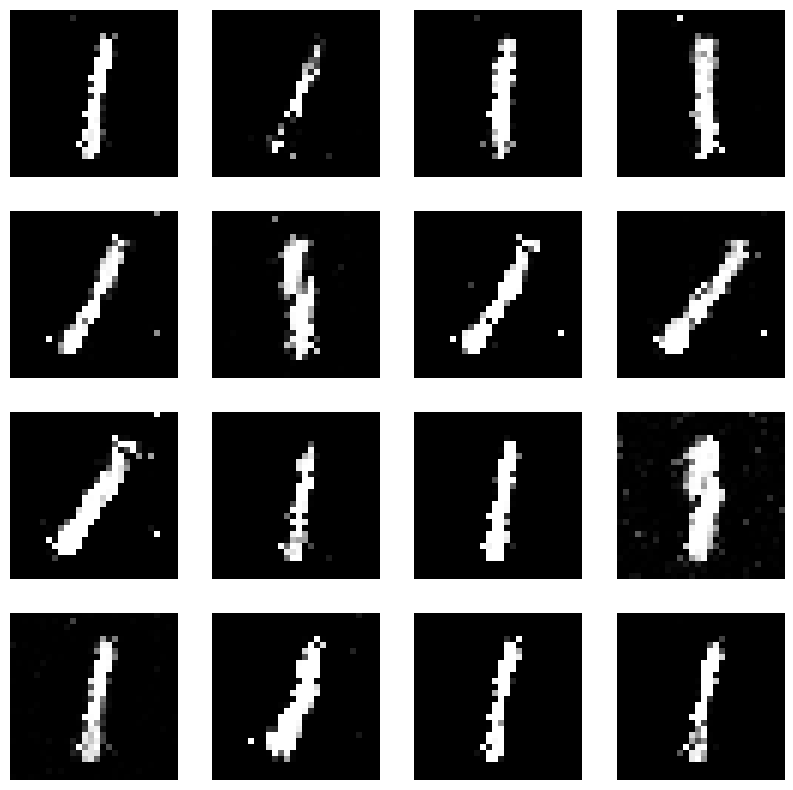

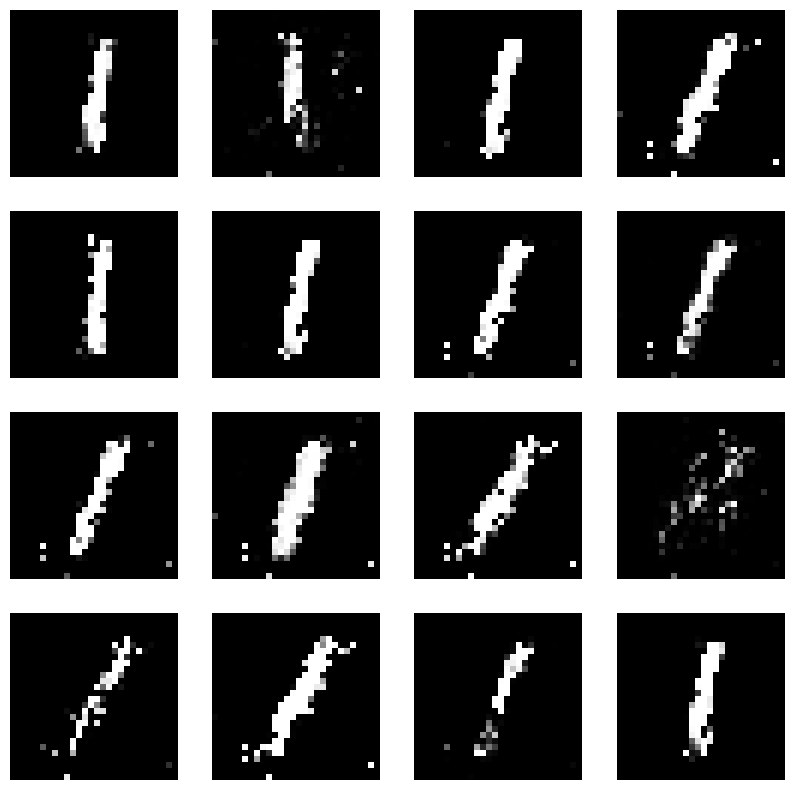

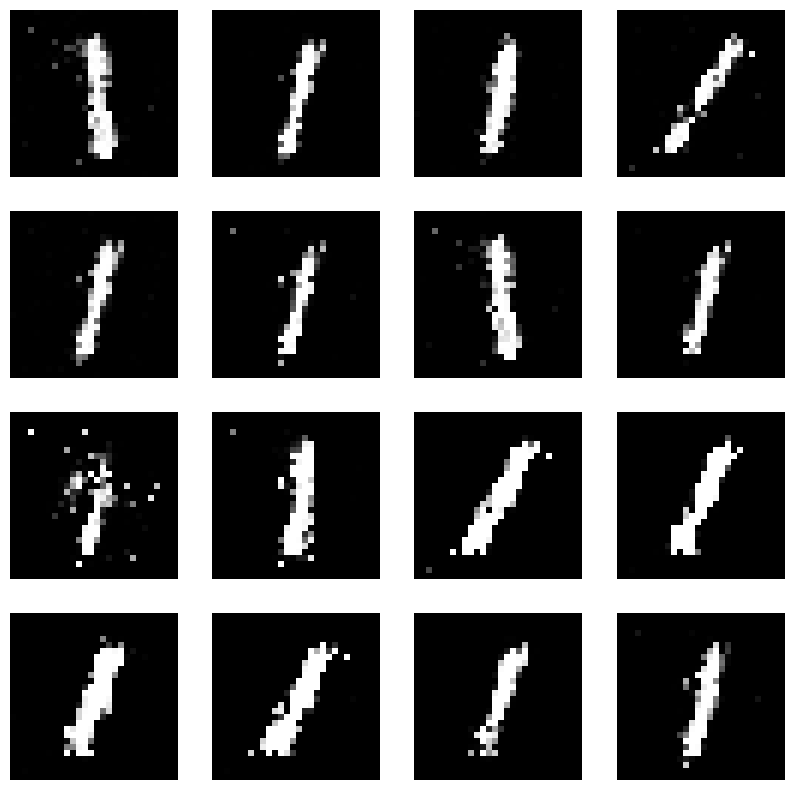

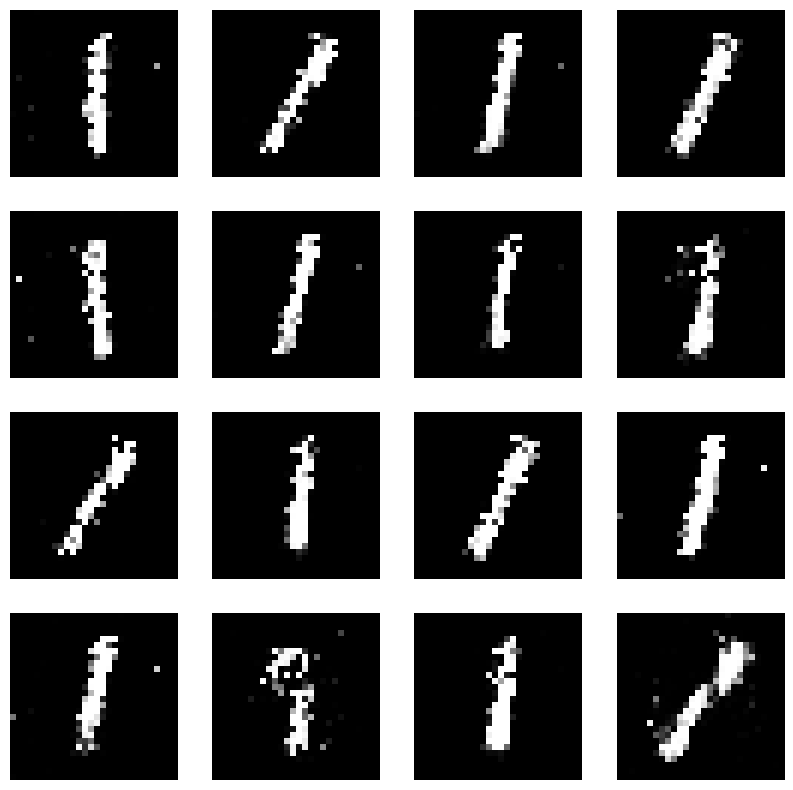

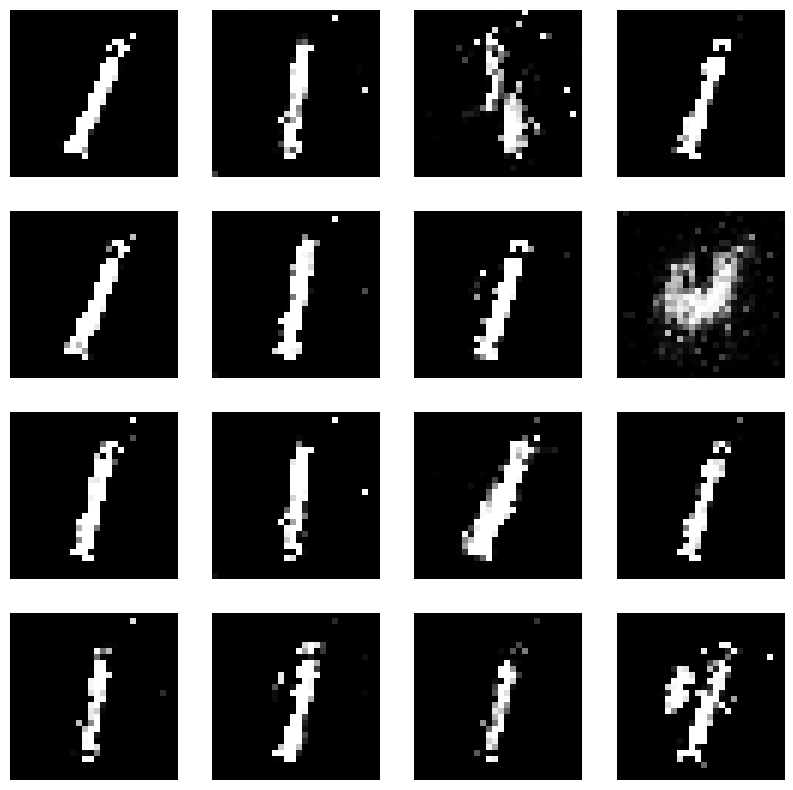

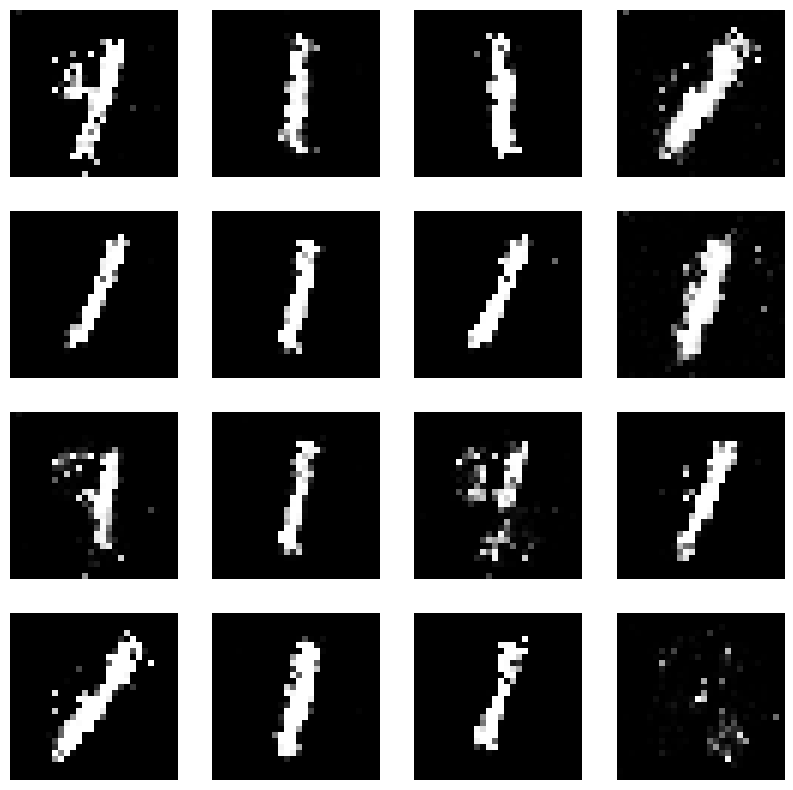

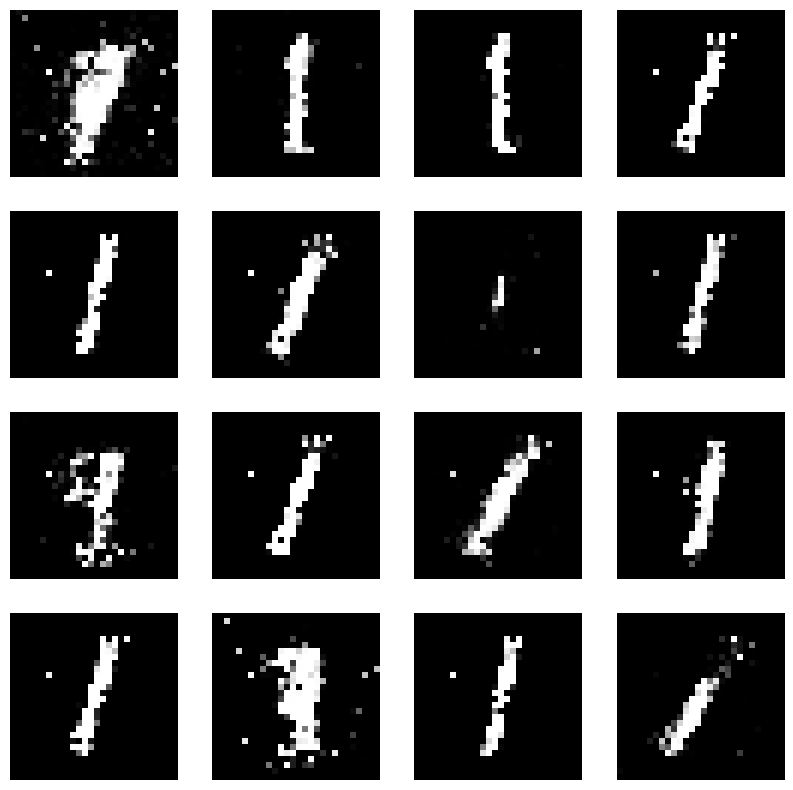

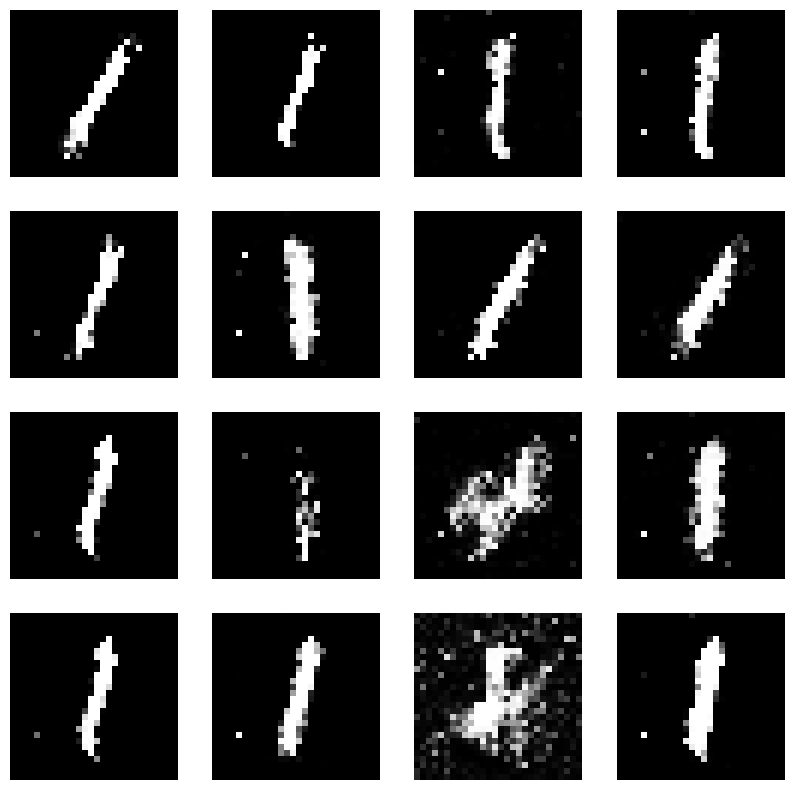

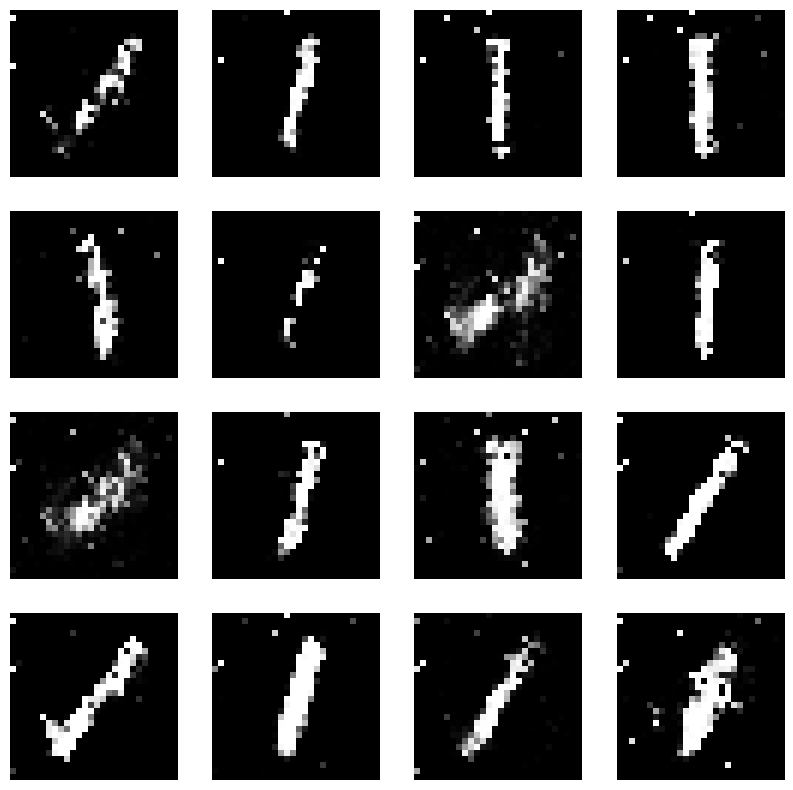

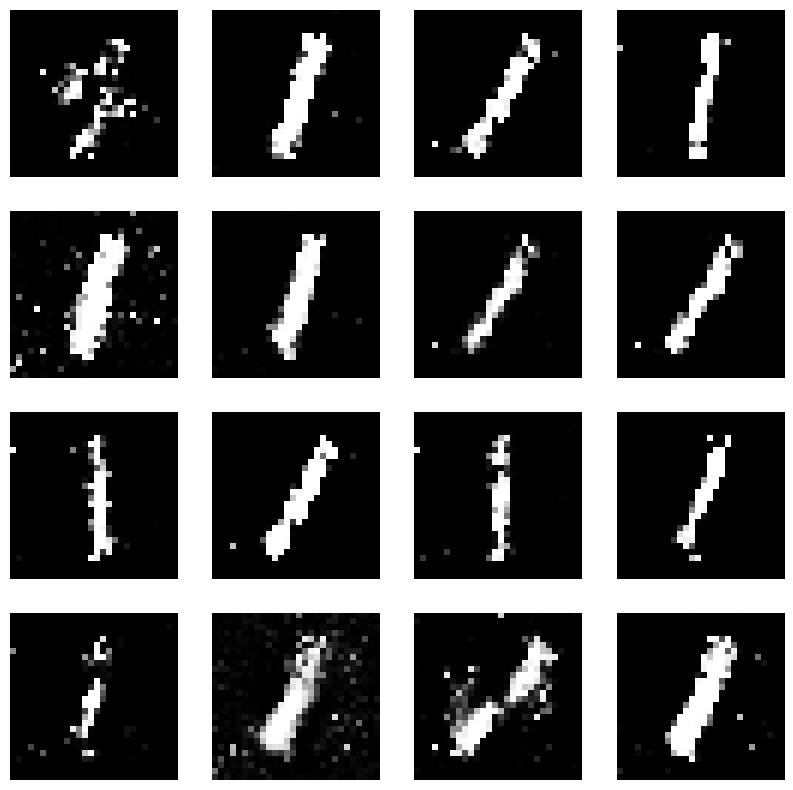

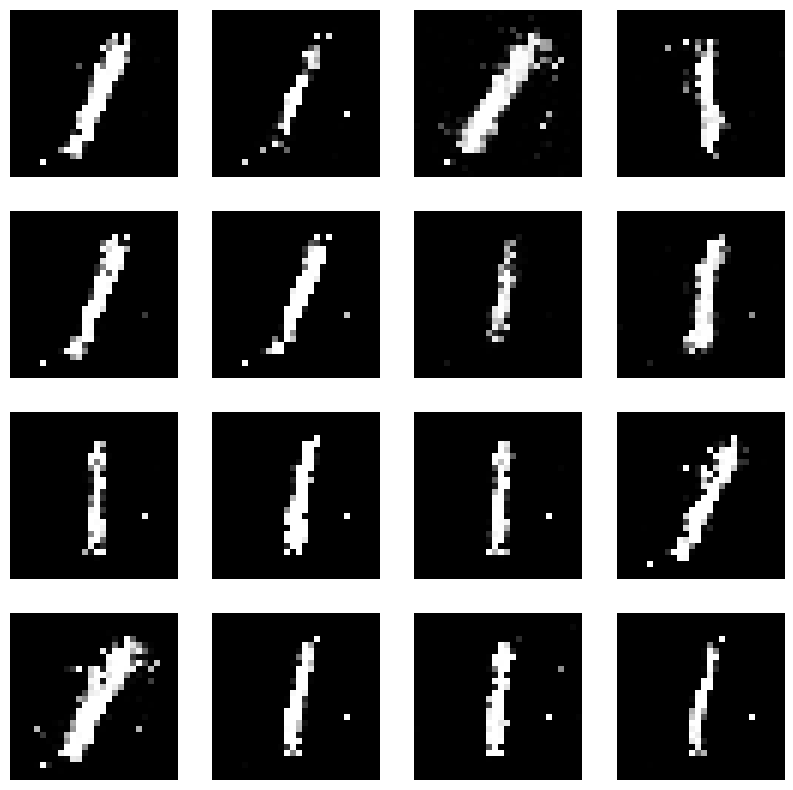

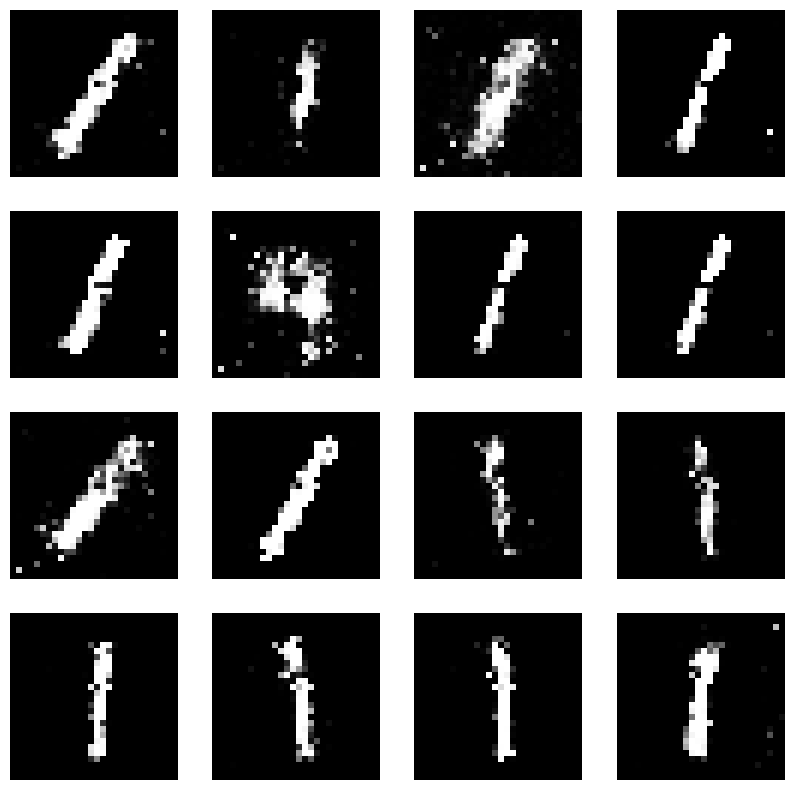

In [10]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import uuid


# Configurable variables
NUM_EPOCHS = 50
NOISE_DIMENSION = 50
BATCH_SIZE = 128
TRAIN_ON_GPU = True
UNIQUE_RUN_ID = str(uuid.uuid4())
PRINT_STATS_AFTER_BATCH = 50
OPTIMIZER_LR = 0.0002
OPTIMIZER_BETAS = (0.5, 0.999)
GENERATOR_OUTPUT_IMAGE_SHAPE = 28 * 28 * 1


# Speed ups
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True


class Generator(nn.Module):
  """
    Vanilla GAN Generator
  """
  def __init__(self,):
    super().__init__()
    self.layers = nn.Sequential(
      # First upsampling
      nn.Linear(NOISE_DIMENSION, 128, bias=False),
      nn.BatchNorm1d(128, 0.8),
      nn.LeakyReLU(0.25),
      # Second upsampling
      nn.Linear(128, 256, bias=False),
      nn.BatchNorm1d(256, 0.8),
      nn.LeakyReLU(0.25),
      # Third upsampling
      nn.Linear(256, 512, bias=False),
      nn.BatchNorm1d(512, 0.8),
      nn.LeakyReLU(0.25),
      # Final upsampling
      nn.Linear(512, GENERATOR_OUTPUT_IMAGE_SHAPE, bias=False),
      nn.Tanh()
    )

  def forward(self, x):
    """Forward pass"""
    return self.layers(x)


class Discriminator(nn.Module):
  """
    Vanilla GAN Discriminator
  """
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(GENERATOR_OUTPUT_IMAGE_SHAPE, 1024), 
      nn.LeakyReLU(0.25),
      nn.Linear(1024, 512), 
      nn.LeakyReLU(0.25),
      nn.Linear(512, 256), 
      nn.LeakyReLU(0.25),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    """Forward pass"""
    return self.layers(x)


def get_device():
  """ Retrieve device based on settings and availability. """
  return torch.device("cuda:0" if torch.cuda.is_available() and TRAIN_ON_GPU else "cpu")
    
    
def make_directory_for_run():
  """ Make a directory for this training run. """
  print(f'Preparing training run {UNIQUE_RUN_ID}')
  if not os.path.exists('./runs'):
    os.mkdir('./runs')
  os.mkdir(f'./runs/{UNIQUE_RUN_ID}')


def generate_image(generator, epoch = 0, batch = 0, device=get_device()):
  """ Generate subplots with generated examples. """
  images = []
  noise = generate_noise(BATCH_SIZE, device=device)
  generator.eval()
  images = generator(noise)
  plt.figure(figsize=(10, 10))
  for i in range(16):
    # Get image
    image = images[i]
    # Convert image back onto CPU and reshape
    image = image.cpu().detach().numpy()
    image = np.reshape(image, (28, 28))
    # Plot
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
  if not os.path.exists(f'./runs/{UNIQUE_RUN_ID}/images'):
    os.mkdir(f'./runs/{UNIQUE_RUN_ID}/images')
  plt.savefig(f'./runs/{UNIQUE_RUN_ID}/images/epoch{epoch}_batch{batch}.jpg')


def save_models(generator, discriminator, epoch):
  """ Save models at specific point in time. """
  torch.save(generator.state_dict(), f'./runs/{UNIQUE_RUN_ID}/generator_{epoch}.pth')
  torch.save(discriminator.state_dict(), f'./runs/{UNIQUE_RUN_ID}/discriminator_{epoch}.pth')


def print_training_progress(batch, generator_loss, discriminator_loss):
  """ Print training progress. """
  print('Losses after mini-batch %5d: generator %e, discriminator %e' %
        (batch, generator_loss, discriminator_loss))


def prepare_dataset():
  """ Prepare dataset through DataLoader """
  # Prepare MNIST dataset
  dataset = MNIST(os.getcwd(), download=True, train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ]))
  # Batch and shuffle data with DataLoader
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
  # Return dataset through DataLoader
  return trainloader


def initialize_models(device = get_device()):
  """ Initialize Generator and Discriminator models """
  generator = Generator()
  discriminator = Discriminator()
  # Move models to specific device
  generator.to(device)
  discriminator.to(device)
  # Return models
  return generator, discriminator


def initialize_loss():
  """ Initialize loss function. """
  return nn.BCELoss()


def initialize_optimizers(generator, discriminator):
  """ Initialize optimizers for Generator and Discriminator. """
  generator_optimizer = torch.optim.AdamW(generator.parameters(), lr=OPTIMIZER_LR,betas=OPTIMIZER_BETAS)
  discriminator_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=OPTIMIZER_LR,betas=OPTIMIZER_BETAS)
  return generator_optimizer, discriminator_optimizer
  

def generate_noise(number_of_images = 1, noise_dimension = NOISE_DIMENSION, device=None):
  """ Generate noise for number_of_images images, with a specific noise_dimension """
  return torch.randn(number_of_images, noise_dimension, device=device)


def efficient_zero_grad(model):
  """ 
    Apply zero_grad more efficiently
    Source: https://betterprogramming.pub/how-to-make-your-pytorch-code-run-faster-93079f3c1f7b
  """
  for param in model.parameters():
    param.grad = None


def forward_and_backward(model, data, loss_function, targets):
  """
    Perform forward and backward pass in a generic way. Returns loss value.
  """
  outputs = model(data)
  error = loss_function(outputs, targets)
  error.backward()
  return error.item()


def perform_train_step(generator, discriminator, real_data, \
  loss_function, generator_optimizer, discriminator_optimizer, device = get_device()):
  """ Perform a single training step. """
  
  # 1. PREPARATION
  # Set real and fake labels.
  real_label, fake_label = 1.0, 0.0
  # Get images on CPU or GPU as configured and available
  # Also set 'actual batch size', whih can be smaller than BATCH_SIZE
  # in some cases.
  real_images = real_data[0].to(device)
  actual_batch_size = real_images.size(0)
  label = torch.full((actual_batch_size,1), real_label, device=device)
  
  # 2. TRAINING THE DISCRIMINATOR
  # Zero the gradients for discriminator
  efficient_zero_grad(discriminator)
  # Forward + backward on real images, reshaped
  real_images = real_images.view(real_images.size(0), -1)
  error_real_images = forward_and_backward(discriminator, real_images, \
    loss_function, label)
  # Forward + backward on generated images
  noise = generate_noise(actual_batch_size, device=device)
  generated_images = generator(noise)
  label.fill_(fake_label)
  error_generated_images =forward_and_backward(discriminator, \
    generated_images.detach(), loss_function, label)
  # Optim for discriminator
  discriminator_optimizer.step()
  
  # 3. TRAINING THE GENERATOR
  # Forward + backward + optim for generator, including zero grad
  efficient_zero_grad(generator)
  label.fill_(real_label)
  error_generator = forward_and_backward(discriminator, generated_images, loss_function, label)
  generator_optimizer.step()
  
  # 4. COMPUTING RESULTS
  # Compute loss values in floats for discriminator, which is joint loss.
  error_discriminator = error_real_images + error_generated_images
  # Return generator and discriminator loss so that it can be printed.
  return error_generator, error_discriminator
  

def perform_epoch(dataloader, generator, discriminator, loss_function, \
    generator_optimizer, discriminator_optimizer, epoch):
  """ Perform a single epoch. """
  for batch_no, real_data in enumerate(dataloader, 0):
    # Perform training step
    generator_loss_val, discriminator_loss_val = perform_train_step(generator, \
      discriminator, real_data, loss_function, \
      generator_optimizer, discriminator_optimizer)
    # Print statistics and generate image after every n-th batch
    if batch_no % PRINT_STATS_AFTER_BATCH == 0:
      print_training_progress(batch_no, generator_loss_val, discriminator_loss_val)
      generate_image(generator, epoch, batch_no)
  # Save models on epoch completion.
  save_models(generator, discriminator, epoch)
  # Clear memory after every epoch
  torch.cuda.empty_cache()
  

def train_dcgan():
  """ Train the DCGAN. """
  # Make directory for unique run
  make_directory_for_run()
  # Set fixed random number seed
  torch.manual_seed(42)
  # Get prepared dataset
  dataloader = prepare_dataset()
  # Initialize models
  generator, discriminator = initialize_models()
  # Initialize loss and optimizers
  loss_function = initialize_loss()
  generator_optimizer, discriminator_optimizer = initialize_optimizers(generator, discriminator)
  # Train the model
  for epoch in range(NUM_EPOCHS):
    print(f'Starting epoch {epoch}...')
    perform_epoch(dataloader, generator, discriminator, loss_function, \
      generator_optimizer, discriminator_optimizer, epoch)
  # Finished :-)
  print(f'Finished unique run {UNIQUE_RUN_ID}')


if __name__ == '__main__':
  train_dcgan()


  